# 초기 설정

## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [2]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [3]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [4]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/root/ml10_regression/data/train.csv'
test_path  = '/root/ml10_regression/data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [5]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [6]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


In [7]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

In [8]:
dt.describe()

,본번,부번,전용면적(㎡),계약년월,계약일,층,건축년도,해제사유발생일,단지소개기존clob,k-전체동수,...,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,건축면적,주차대수,좌표X,좌표Y,target
count,1.118747e+06,1.118747e+06,1.118822e+06,1.118822e+06,1.118822e+06,1.118822e+06,1.118822e+06,5.983000e+03,68582.000000,248192.000000,...,249259.000000,249214.000000,249214.000000,249214.000000,327.0,2.491080e+05,249108.000000,249152.000000,249152.000000,1.118822e+06
mean,5.649108e+02,5.978885e+00,7.717475e+01,2.014760e+05,1.580656e+01,8.871968e+00,1.998755e+03,2.021057e+07,541.529979,14.798346,...,120726.487549,477.912838,476.713439,167.528470,70.0,1.895070e+05,1063.678778,126.995228,37.545785,5.799153e+04
std,5.160642e+02,4.668584e+01,2.936423e+01,4.187868e+02,8.721166e+00,5.982584e+00,9.333908e+00,1.060697e+04,751.809853,17.693533,...,129020.276480,759.909400,727.553569,248.928143,0.0,1.729027e+06,1235.437604,0.091045,0.052483,4.642602e+04
min,0.000000e+00,0.000000e+00,1.002000e+01,2.007010e+05,1.000000e+00,-4.000000e+00,1.961000e+03,2.020022e+07,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,70.0,0.000000e+00,0.000000,126.798318,37.447843,3.500000e+02
25%,1.760000e+02,0.000000e+00,5.965000e+01,2.011100e+05,8.000000e+00,4.000000e+00,1.992000e+03,2.020082e+07,4.000000,5.000000,...,40735.000000,48.000000,95.000000,0.000000,70.0,0.000000e+00,315.000000,126.913157,37.499201,3.050000e+04
50%,4.700000e+02,0.000000e+00,8.188000e+01,2.015070e+05,1.600000e+01,8.000000e+00,2.000000e+03,2.021030e+07,174.000000,10.000000,...,78125.000000,225.000000,256.000000,63.000000,70.0,1.710550e+03,683.000000,127.014971,37.544936,4.480000e+04
75%,7.810000e+02,1.000000e+00,8.496000e+01,2.018040e+05,2.300000e+01,1.200000e+01,2.005000e+03,2.022021e+07,725.000000,17.000000,...,159544.000000,576.000000,582.000000,237.000000,70.0,8.414210e+03,1274.000000,127.059590,37.577117,6.980000e+04
max,4.974000e+03,2.837000e+03,4.243200e+02,2.023060e+05,3.100000e+01,6.900000e+01,2.023000e+03,2.023093e+07,2888.000000,124.000000,...,969877.000000,4975.000000,5132.000000,1500.000000,70.0,3.159620e+07,12096.000000,127.179998,37.687725,1.450000e+06


## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [9]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [10]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [11]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


In [12]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

            1111271
20230630        585
20230831        496
20230428        394
20230731        374
             ...   
20230105          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: 등기신청일자, Length: 182, dtype: int64

In [13]:
display(concat['거래유형'].value_counts())

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [14]:
display(concat['중개사소재지'].value_counts())

-                    1090013
서울 노원구                  2627
서울 송파구                  2540
서울 강남구                  2508
서울 강동구                  2038
                      ...   
서울 강북구, 서울 양천구             1
경기 남양주시, 경기 성남수정구          1
서울 송파구, 인천 계양구             1
경기 연천군, 서울 송파구             1
서울 중랑구, 인천 부평구             1
Name: 중개사소재지, Length: 739, dtype: int64

In [15]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [16]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

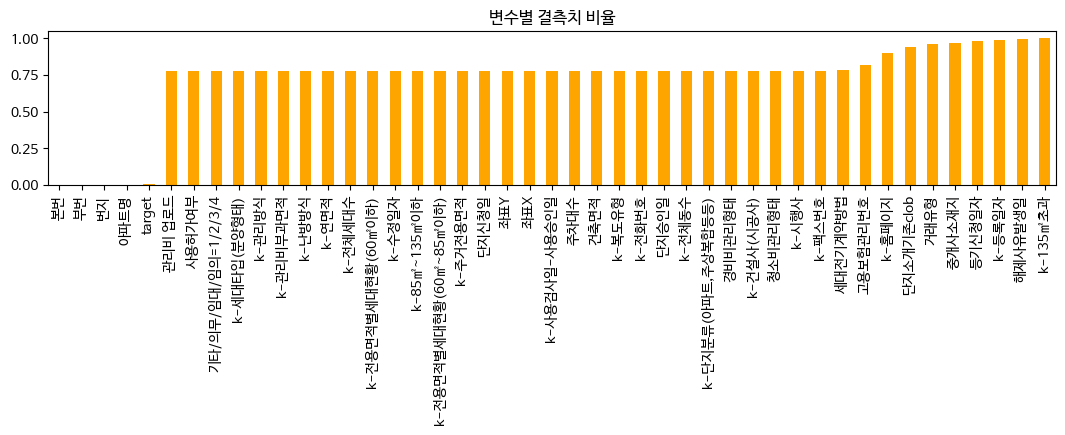

In [17]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [18]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [19]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [20]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구                            0
번지                           227
본번                            75
부번                            75
아파트명                        2136
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
k-단지분류(아파트,주상복합등등)        877273
k-전화번호                    876850
k-팩스번호                    879348
k-세대타입(분양형태)              876125
k-관리방식                    876125
k-복도유형                    876454
k-난방방식                    876125
k-전체동수                    877207
k-전체세대수                   876125
k-건설사(시공사)                877637
k-시행사                     877834
k-사용검사일-사용승인일             876259
k-연면적                     876125
k-주거전용면적                  876170
k-관리비부과면적                 876125
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현황(60㎡~85㎡이하)    876170
k-85㎡~135㎡이하              876170
k-수정일자                    876170
고용보험관리번호  

In [21]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 45 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 12  k-전화번호                  251244 non-null   object 
 13  k-팩스번호                  248746 non-null   object 
 14  k-세대타

In [22]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [23]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


# EDA

### 타겟 변수 파악

In [24]:
df = concat_select.copy()

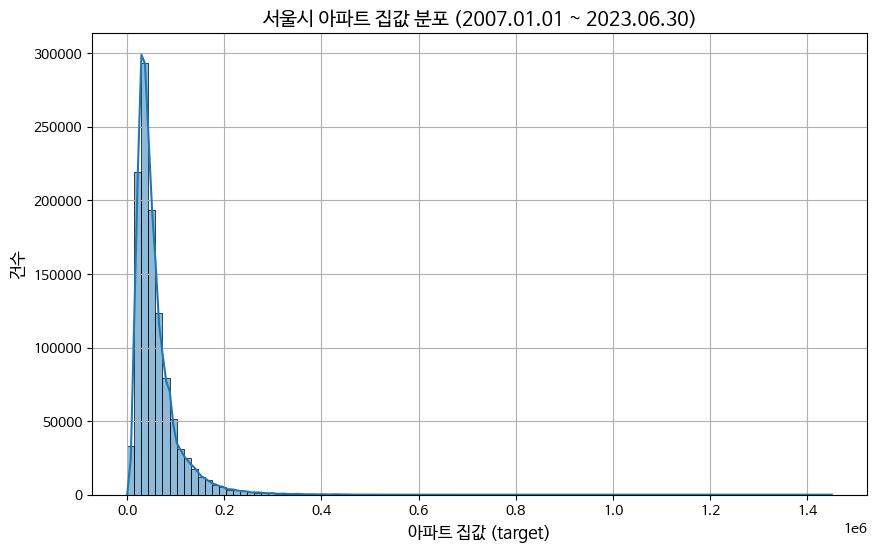

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일 설정
plt.figure(figsize=(10, 6))
sns.histplot(df['target'], bins=100, kde=True)

# 그래프 제목 및 축 라벨 설정
plt.title('서울시 아파트 집값 분포 (2007.01.01 ~ 2023.06.30)', fontsize=14)
plt.xlabel('아파트 집값 (target)', fontsize=12)
plt.ylabel('건수', fontsize=12)
plt.grid(True)

plt.show()

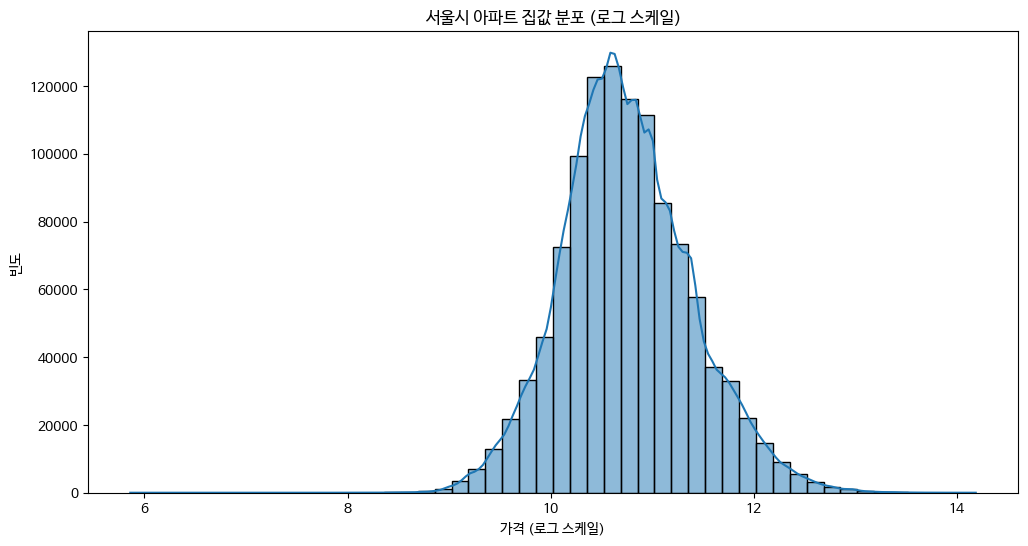

In [83]:
# 로그 스케일 적용한 집값 분포 히스토그램 (왜도가 큰 경우 유용)
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(df[df['is_test']==0]['target']), bins=50, kde=True)
plt.title('서울시 아파트 집값 분포 (로그 스케일)')
plt.xlabel('가격 (로그 스케일)')
plt.ylabel('빈도')
plt.show()

타겟 변수의 왜도값이 큰 것으로 보임

In [84]:
df['계약년월']

0       201712
1       201712
2       201712
3       201801
4       201801
         ...  
9267    202307
9268    202307
9269    202308
9270    202309
9271    202309
Name: 계약년월, Length: 1128094, dtype: int64

### 타겟변수와 시간과의 관계

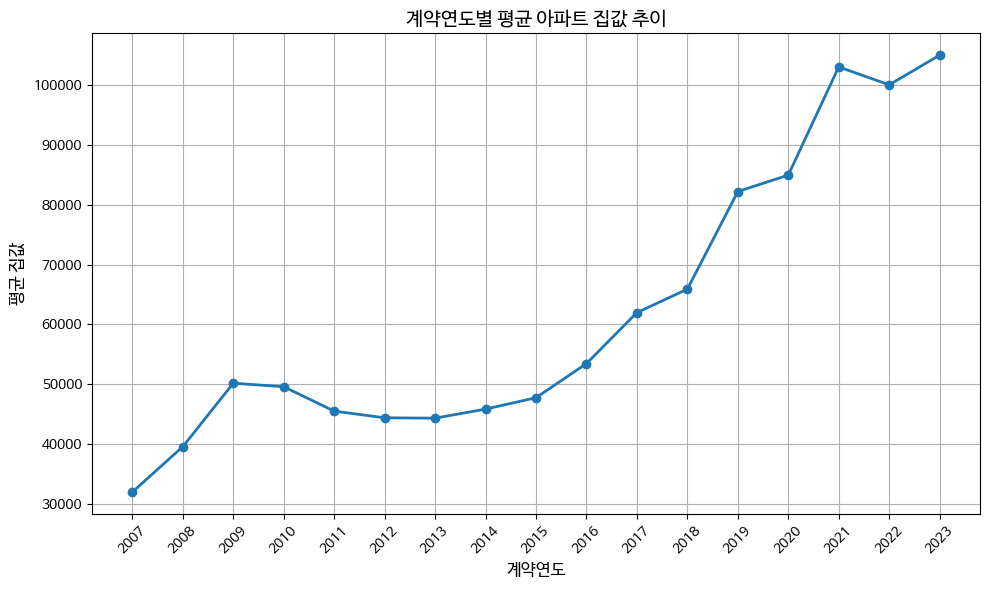

In [85]:
# 계약연도와 계약월 컬럼 생성
df['계약연도'] = df['계약년월'] // 100
df['계약월'] = df['계약년월'] % 100

# 계약연도별 평균 집값 계산
yearly_avg_price = df.groupby('계약연도')['target'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(yearly_avg_price['계약연도'], yearly_avg_price['target'], marker='o', linewidth=2)

# 그래프 설정
plt.title('계약연도별 평균 아파트 집값 추이', fontsize=14)
plt.xlabel('계약연도', fontsize=12)
plt.ylabel('평균 집값', fontsize=12)
plt.grid(True)

plt.xticks(yearly_avg_price['계약연도'], rotation=45)
plt.tight_layout()
plt.show()

2016년을 기준으로 집값이 상승한것 같음 

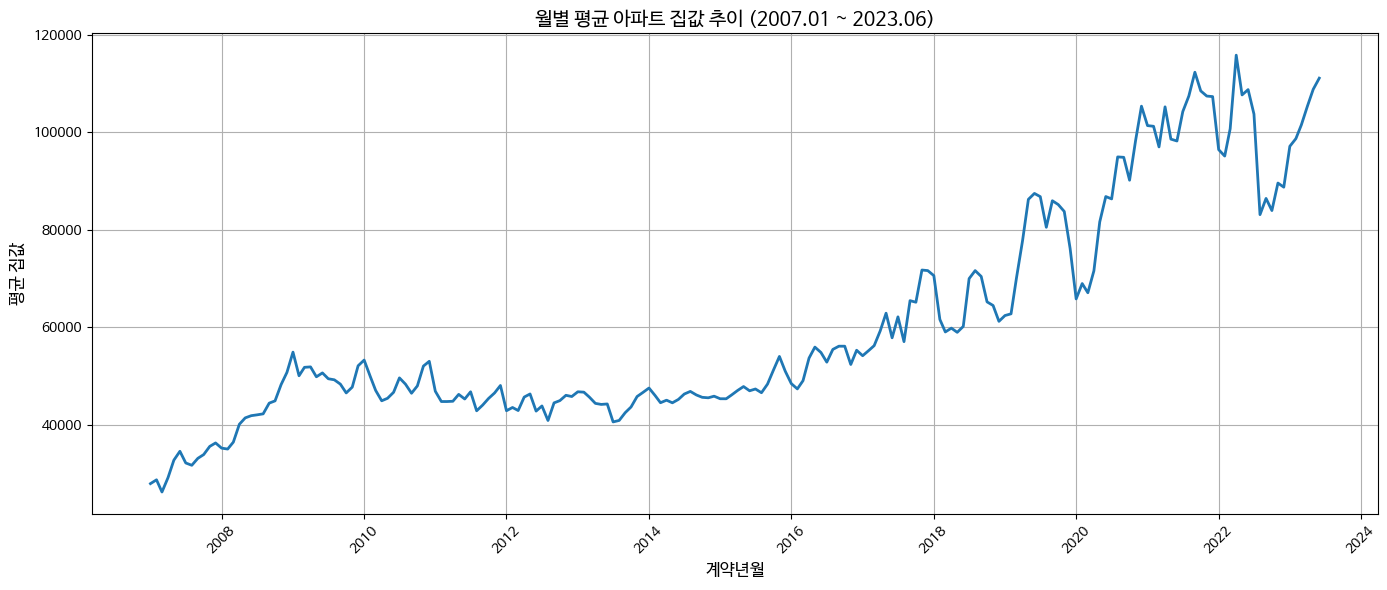

In [86]:
# 계약년월을 문자열로 변환 후 'YYYYMM' 형식으로 datetime 처리
df['계약년월_dt'] = pd.to_datetime(df['계약년월'].astype(str), format='%Y%m')

# 월별 평균 집값 계산
monthly_avg_price = df.groupby('계약년월_dt')['target'].mean().reset_index()

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(monthly_avg_price['계약년월_dt'], monthly_avg_price['target'], linewidth=2)

# 그래프 설정
plt.title('월별 평균 아파트 집값 추이 (2007.01 ~ 2023.06)', fontsize=14)
plt.xlabel('계약년월', fontsize=12)
plt.ylabel('평균 집값', fontsize=12)
plt.grid(True)

# x축 날짜 간격 조정
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


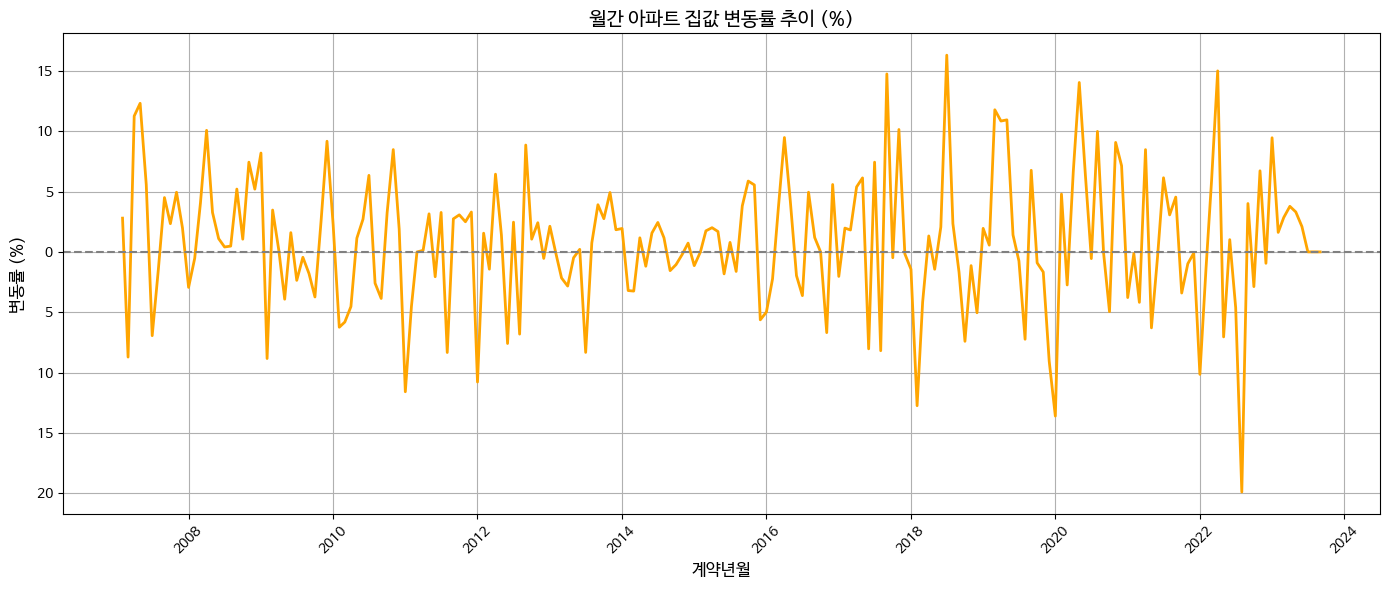

In [87]:
# 계약년월 기준 월별 평균 집값 다시 정리 (datetime 기준)
monthly_avg_price = df.groupby('계약년월_dt')['target'].mean().reset_index()

# 변동률 계산: (이번달 - 지난달) / 지난달 * 100
monthly_avg_price['변동률(%)'] = monthly_avg_price['target'].pct_change() * 100

plt.figure(figsize=(14, 6))
plt.plot(monthly_avg_price['계약년월_dt'], monthly_avg_price['변동률(%)'], color='orange', linewidth=2)
plt.axhline(0, color='gray', linestyle='--')  # 기준선

# 그래프 설정
plt.title('월간 아파트 집값 변동률 추이 (%)', fontsize=14)
plt.xlabel('계약년월', fontsize=12)
plt.ylabel('변동률 (%)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


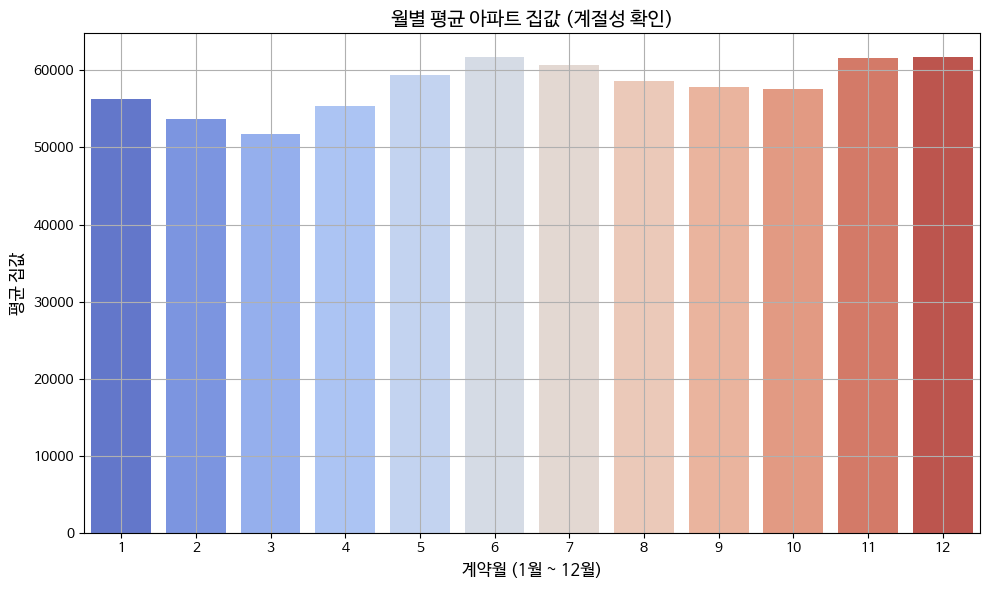

In [88]:
# 계약월 기준 월별 평균 집값 계산
monthly_seasonal_avg = df.groupby('계약월')['target'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_seasonal_avg, x='계약월', y='target', palette='coolwarm')

# 그래프 설정
plt.title('월별 평균 아파트 집값 (계절성 확인)', fontsize=14)
plt.xlabel('계약월 (1월 ~ 12월)', fontsize=12)
plt.ylabel('평균 집값', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

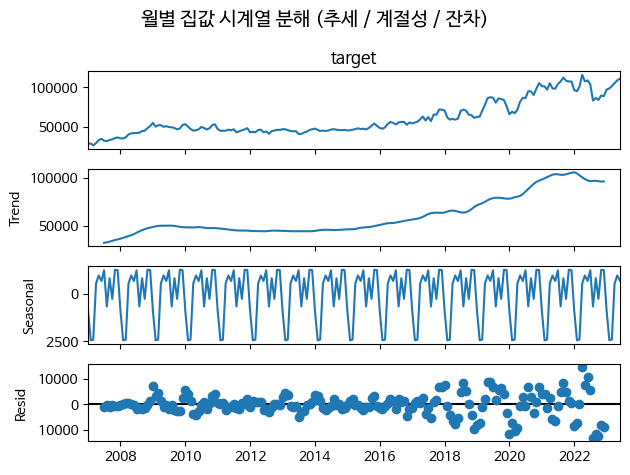

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 계약년월을 datetime으로 정리하고 월별 평균 집값 생성
dt['계약년월_dt'] = pd.to_datetime(dt['계약년월'], format='%Y%m')
# 계약년월을 datetime으로 정리하고 월별 평균 집값 생성
monthly_series = dt.groupby('계약년월_dt')['target'].mean()

# 시계열 분해: additive (덧셈 모델) 또는 multiplicative (곱셈 모델)
decomposition = seasonal_decompose(monthly_series, model='additive', period=12)
decomposition.plot()
plt.suptitle('월별 집값 시계열 분해 (추세 / 계절성 / 잔차)', fontsize=14)
plt.tight_layout()
plt.show()


In [90]:
# 시계열 분해
result = seasonal_decompose(monthly_series, model='additive', period=12)

# seasonal 요소 추출
seasonal = result.seasonal

# 앞부분 살펴보기
print(seasonal.head(24))  # 2년치 계절성 확인

계약년월_dt
2007-01-01    -879.834564
2007-02-01   -2446.723868
2007-03-01   -2411.130539
2007-04-01     533.023429
2007-05-01     954.694551
2007-06-01     666.795151
2007-07-01    1225.767382
2007-08-01    -669.642136
2007-09-01     810.948611
2007-10-01    -274.004668
2007-11-01    1255.393898
2007-12-01    1234.712755
2008-01-01    -879.834564
2008-02-01   -2446.723868
2008-03-01   -2411.130539
2008-04-01     533.023429
2008-05-01     954.694551
2008-06-01     666.795151
2008-07-01    1225.767382
2008-08-01    -669.642136
2008-09-01     810.948611
2008-10-01    -274.004668
2008-11-01    1255.393898
2008-12-01    1234.712755
Name: seasonal, dtype: float64


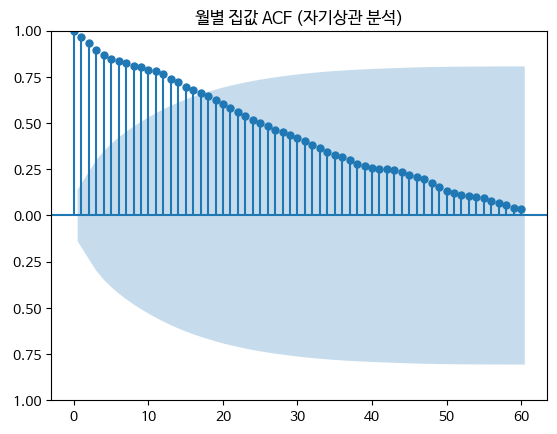

In [91]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(monthly_series.dropna(), lags=60)
plt.title('월별 집값 ACF (자기상관 분석)')
plt.show()

3 5월이 수요량은 사실 더 많음

급처, 월별 계약 건수 확인해보기

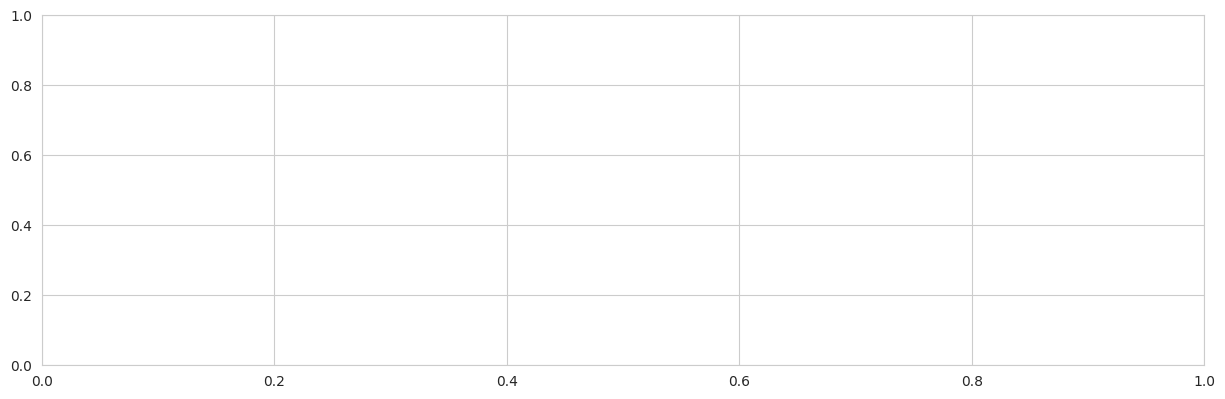

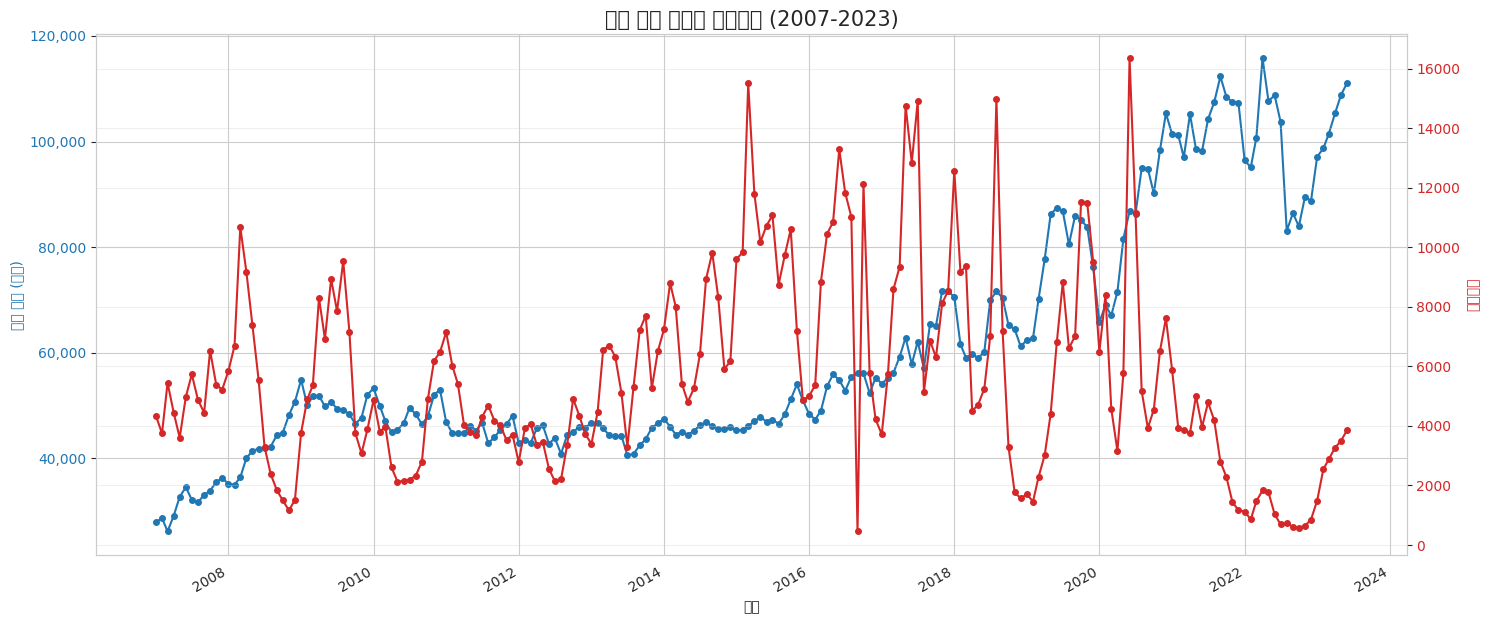

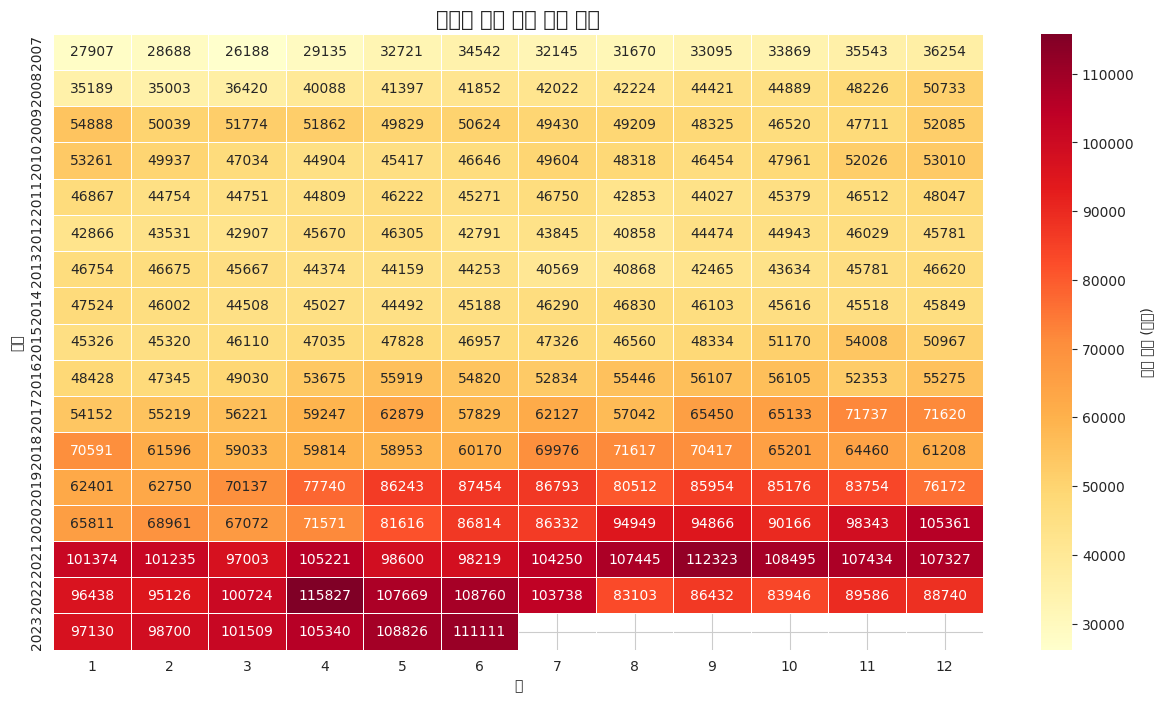

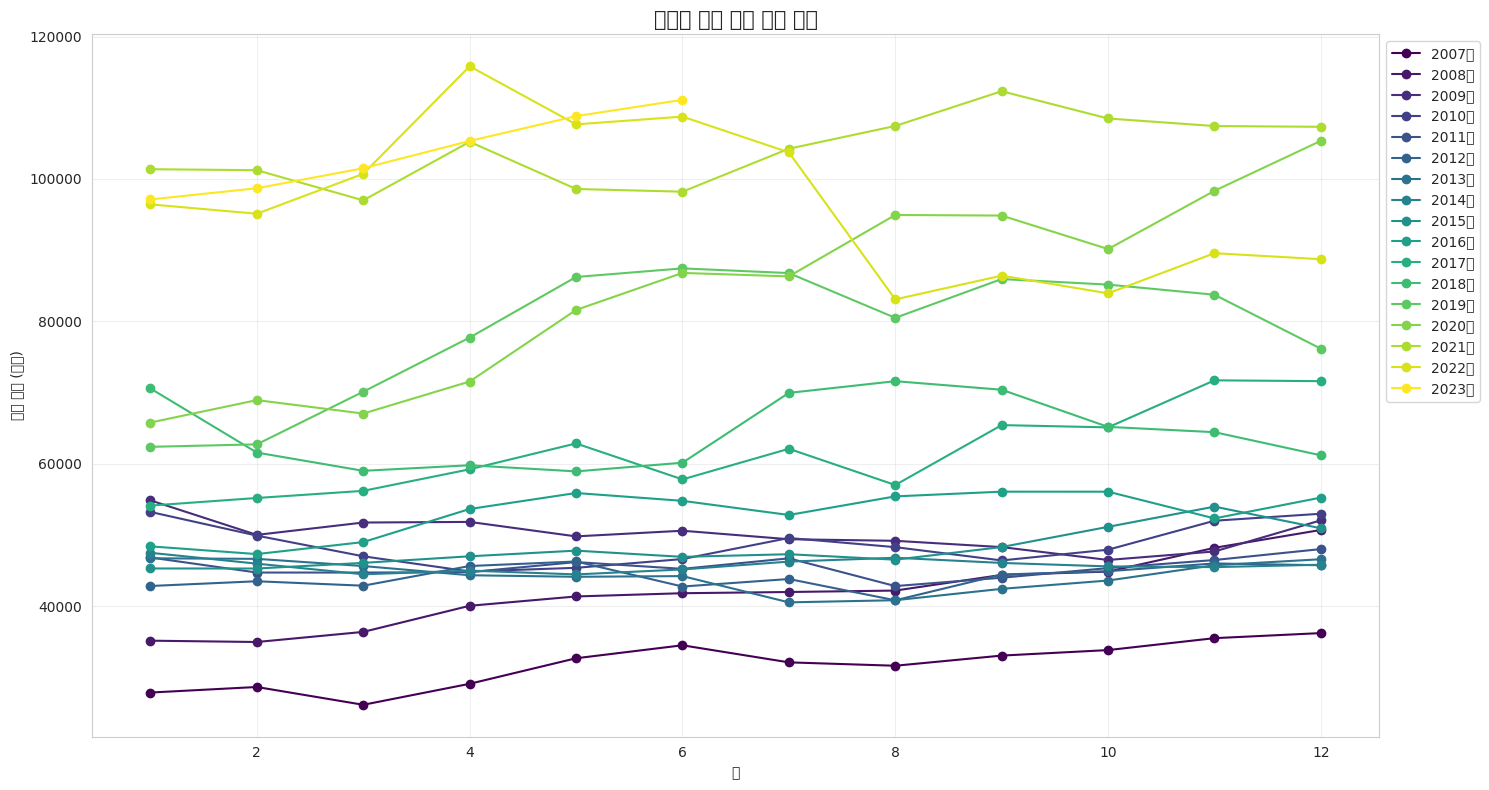

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter


# 스타일 설정
plt.figure(figsize=(15, 10))

# 1. 월별 평균 집값과 계약건수 시각화
plt.subplot(2, 1, 1)

# 월별 평균 집값과 계약건수 계산
monthly_stats = df.groupby(['계약연도', '계약월']).agg(
    평균집값=('target', 'mean'),
    계약건수=('target', 'count')
).reset_index()
monthly_stats = monthly_stats.iloc[:-3]
# 날짜 형식으로 변환하여 정렬
monthly_stats['날짜'] = pd.to_datetime(monthly_stats['계약연도'].astype(str) + '-' + monthly_stats['계약월'].astype(str) + '-01')
monthly_stats = monthly_stats.sort_values('날짜')

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(15, 7))

# 첫 번째 Y축: 평균 집값
color = 'tab:blue'
ax1.set_xlabel('날짜')
ax1.set_ylabel('평균 집값 (만원)', color=color)
ax1.plot(monthly_stats['날짜'], monthly_stats['평균집값'], color=color, marker='o', linestyle='-', markersize=4)
ax1.tick_params(axis='y', labelcolor=color)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

# 두 번째 Y축: 계약건수
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('계약건수', color=color)
ax2.plot(monthly_stats['날짜'], monthly_stats['계약건수'], color=color, marker='o', linestyle='-', markersize=4)
ax2.tick_params(axis='y', labelcolor=color)

# 그래프 제목과 레이아웃 설정
plt.title('월별 평균 집값과 계약건수 (2007-2023)', fontsize=15)
fig.tight_layout()
plt.grid(True, alpha=0.3)

# x축 날짜 표시 개선
plt.gcf().autofmt_xdate()

# 2. 연도별 월별 평균 집값 히트맵
plt.figure(figsize=(15, 8))

# 연도와 월별 평균 집값 피벗 테이블 생성
pivot_df = monthly_stats.pivot_table(index='계약연도', columns='계약월', values='평균집값')

# 히트맵 그리기
ax = sns.heatmap(pivot_df, cmap='YlOrRd', annot=True, fmt='.0f', 
                 linewidths=.5, cbar_kws={'label': '평균 집값 (만원)'})

plt.title('연도별 월별 평균 집값 비교', fontsize=15)
plt.xlabel('월')
plt.ylabel('연도')

# 3. 월별 평균 집값의 연도별 추이 (라인 그래프)
plt.figure(figsize=(15, 8))

# 연도별로 다른 색상 사용
years = sorted(monthly_stats['계약연도'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(years)))

for i, year in enumerate(years):
    year_data = monthly_stats[monthly_stats['계약연도'] == year]
    plt.plot(year_data['계약월'], year_data['평균집값'], 
             marker='o', linestyle='-', label=f'{year}년', color=colors[i])

plt.title('연도별 월별 평균 집값 추이', fontsize=15)
plt.xlabel('월')
plt.ylabel('평균 집값 (만원)')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

# 그래프 출력
plt.show()

월별로 값이 다른것같은데 사이클릭인코딩을 통해 계절성을 탐지해보도록 하는 방법 좋을듯

### 타겟변수와 시군구와 관계

In [ ]:
df['시군구']

0       서울특별시 강남구 개포동
1       서울특별시 강남구 개포동
2       서울특별시 강남구 개포동
3       서울특별시 강남구 개포동
4       서울특별시 강남구 개포동
            ...      
9267    서울특별시 중랑구 신내동
9268    서울특별시 중랑구 신내동
9269    서울특별시 중랑구 신내동
9270    서울특별시 중랑구 신내동
9271    서울특별시 중랑구 신내동
Name: 시군구, Length: 1128094, dtype: object

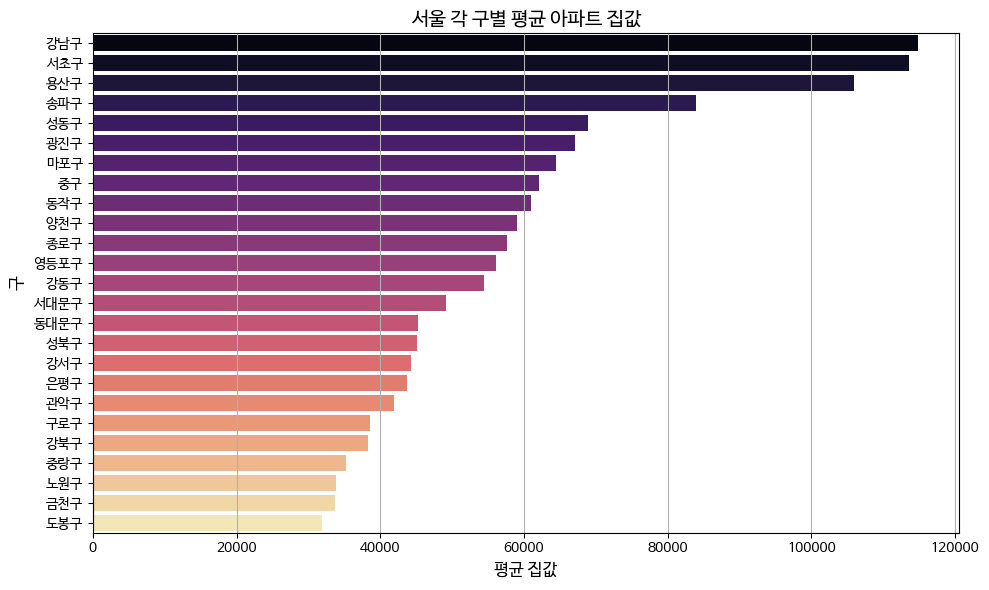

In [92]:
# 시군구 문자열을 공백 기준으로 분할
df[['시', '구', '동']] = df['시군구'].str.split(expand=True)
# '구' 단위로 평균 집값 계산
gu_avg_price = df.groupby('구')['target'].mean().reset_index().sort_values(by='target', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=gu_avg_price, x='target', y='구', palette='magma')

plt.title('서울 각 구별 평균 아파트 집값', fontsize=14)
plt.xlabel('평균 집값', fontsize=12)
plt.ylabel('구', fontsize=12)
plt.grid(axis='x')

plt.tight_layout()
plt.show()


In [93]:
mean_price_by_gu_year = df.groupby(['계약연도', '구'])['target'].mean().reset_index()
pivoted = mean_price_by_gu_year.pivot(index='구', columns='계약연도', values='target')

# 집값 상승률 계산: (마지막 해 / 첫 해) - 1
pivoted['상승률'] = (pivoted[2023] / pivoted[2007]) - 1

# 상승률 기준 정렬
pivoted_sorted = pivoted.sort_values('상승률', ascending=False)
print(pivoted_sorted[['상승률']])


계약연도       상승률
구             
종로구   2.593696
마포구   2.184810
서초구   2.166442
강서구   2.087980
용산구   2.082268
강남구   2.036904
서대문구  1.967673
성동구   1.960637
노원구   1.930191
영등포구  1.906531
양천구   1.892437
은평구   1.882495
금천구   1.832401
동대문구  1.696289
성북구   1.677118
강동구   1.675565
송파구   1.647453
중랑구   1.636812
중구    1.619622
광진구   1.567585
동작구   1.495241
도봉구   1.474537
구로구   1.458305
강북구   1.350834
관악구   1.241348


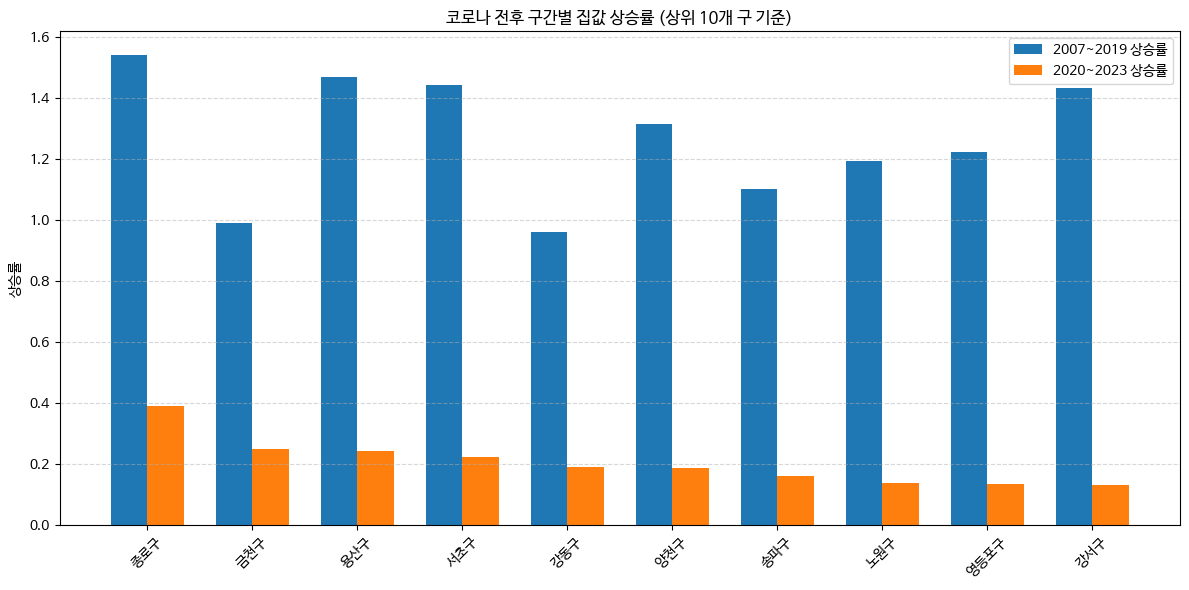

In [94]:
import matplotlib.pyplot as plt
import numpy as np
pivoted = mean_price_by_gu_year.pivot(index='구', columns='계약연도', values='target')

# 상승률 계산: (후기 - 전기) / 전기
pivoted['2007~2019 상승률'] = (pivoted[2019] - pivoted[2007]) / pivoted[2007]
pivoted['2020~2023 상승률'] = (pivoted[2023] - pivoted[2020]) / pivoted[2020]

# 상승률만 추출
slope_df = pivoted[['2007~2019 상승률', '2020~2023 상승률']].reset_index()
# 상위 10개 구 기준 예시
top10 = slope_df.sort_values('2020~2023 상승률', ascending=False).head(10)

labels = top10['구']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, top10['2007~2019 상승률'], width, label='2007~2019 상승률')
bars2 = ax.bar(x + width/2, top10['2020~2023 상승률'], width, label='2020~2023 상승률')

ax.set_ylabel('상승률')
ax.set_title('코로나 전후 구간별 집값 상승률 (상위 10개 구 기준)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



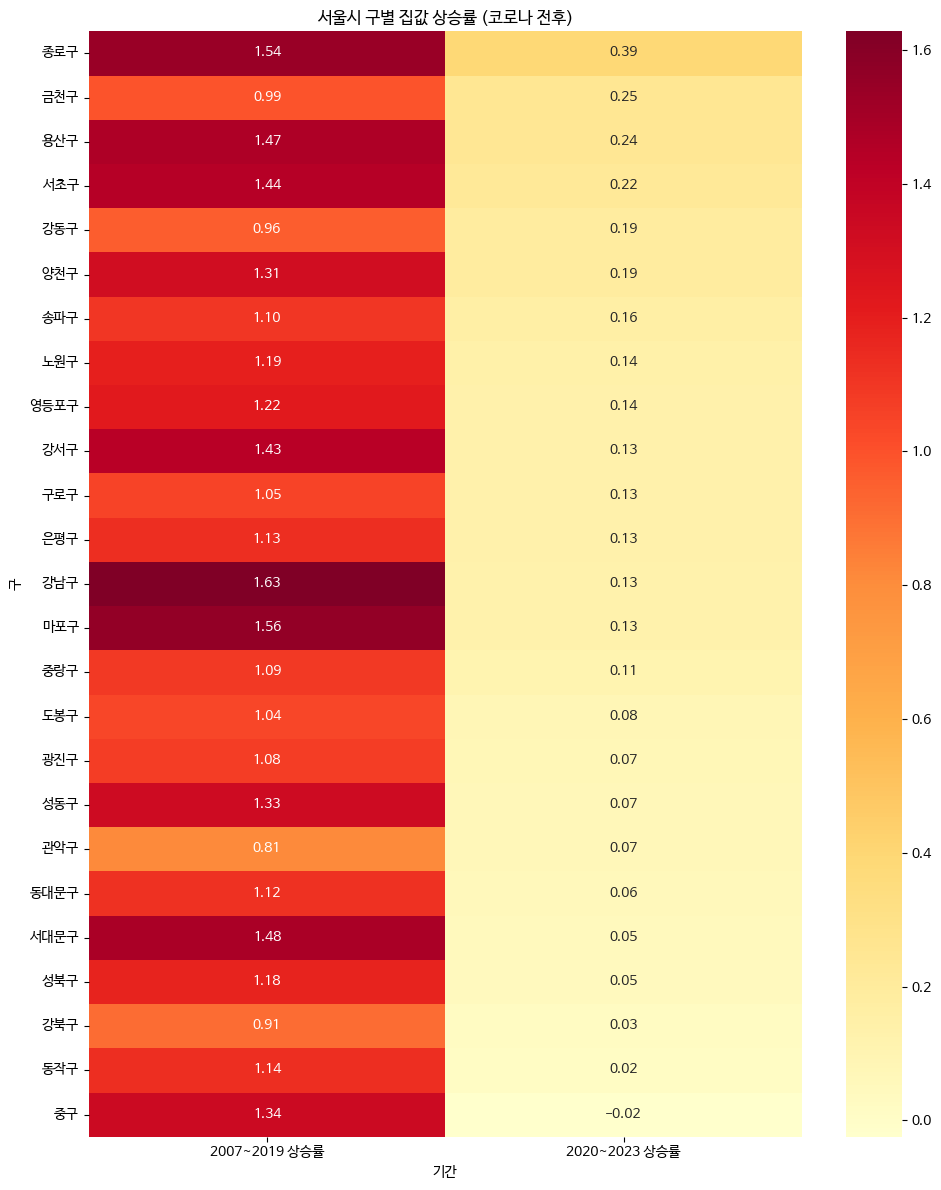

In [95]:
import seaborn as sns

# 상승률 데이터만 히트맵용으로 정리
heat_df = slope_df.set_index('구')[['2007~2019 상승률', '2020~2023 상승률']]

plt.figure(figsize=(10, 12))
sns.heatmap(heat_df.sort_values('2020~2023 상승률', ascending=False), annot=True, fmt=".2f", cmap='YlOrRd')
plt.title('서울시 구별 집값 상승률 (코로나 전후)')
plt.xlabel('기간')
plt.ylabel('구')
plt.tight_layout()
plt.show()


### 전용면적과 집값과의 관계

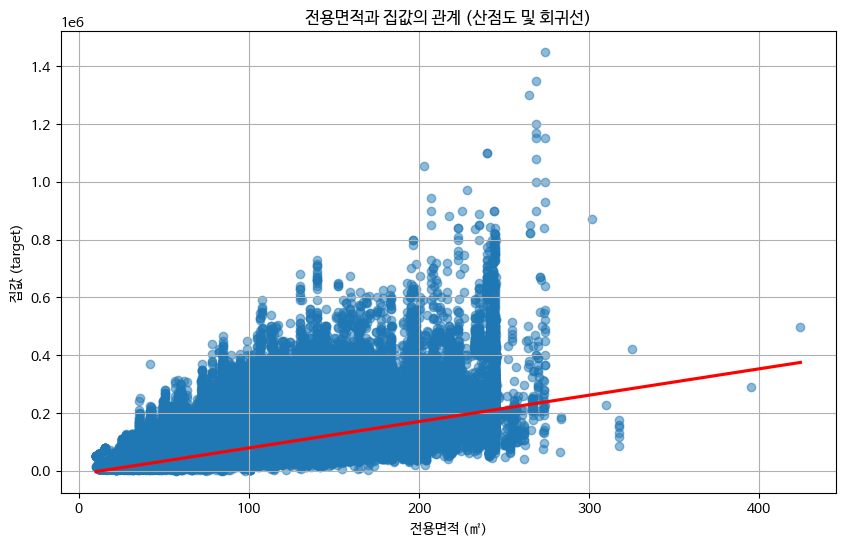

In [97]:
# 산점도와 회귀선 포함 산점도 시각화 함수 정의
def plot_scatter_with_regression(df):
    plt.figure(figsize=(10, 6))
    sns.regplot(x='전용면적', y='target', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title('전용면적과 집값의 관계 (산점도 및 회귀선)')
    plt.xlabel('전용면적 (㎡)')
    plt.ylabel('집값 (target)')
    plt.grid(True)
    plt.show()


plot_scatter_with_regression(df)


월별 계약건수 가격 평균내서 관계 확인해보면 좋을듯

### 층과 집값과의 관계

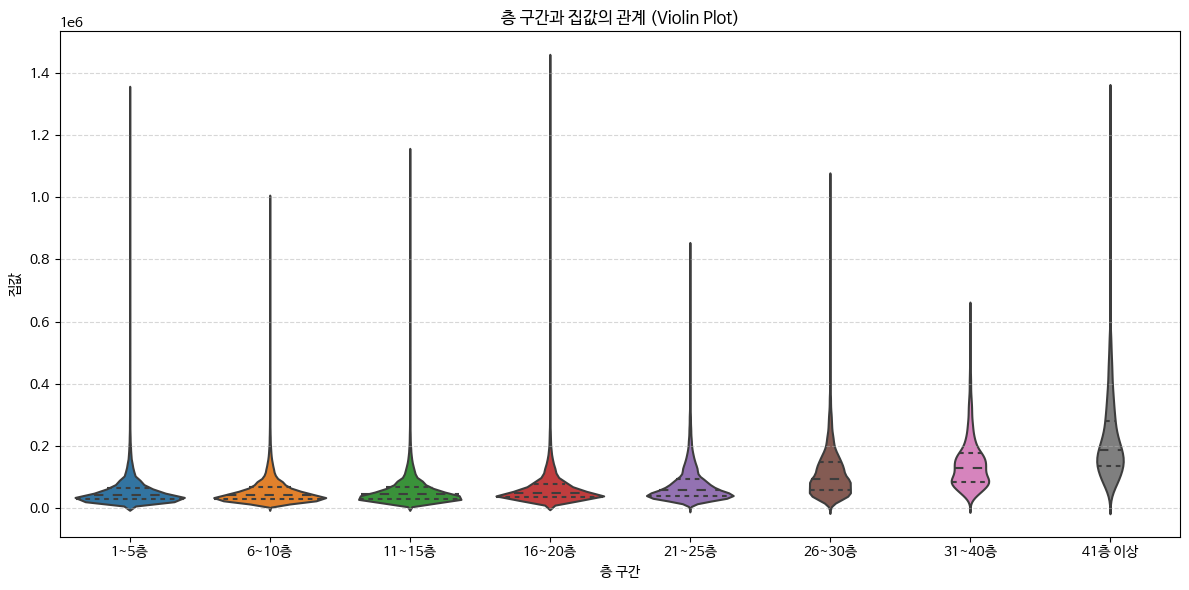

In [115]:
# 층을 범주형 구간으로 그룹화
df['층구간'] = pd.cut(df['층'], bins=[0, 5, 10, 15, 20, 25, 30, 40, 100],
                     labels=['1~5층', '6~10층', '11~15층', '16~20층', '21~25층', '26~30층', '31~40층', '41층 이상'])

plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='층구간', y='target', inner='quartile')
plt.title('층 구간과 집값의 관계 (Violin Plot)')
plt.xlabel('층 구간')
plt.ylabel('집값')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 세대수/단지규모와 집값과의 관계

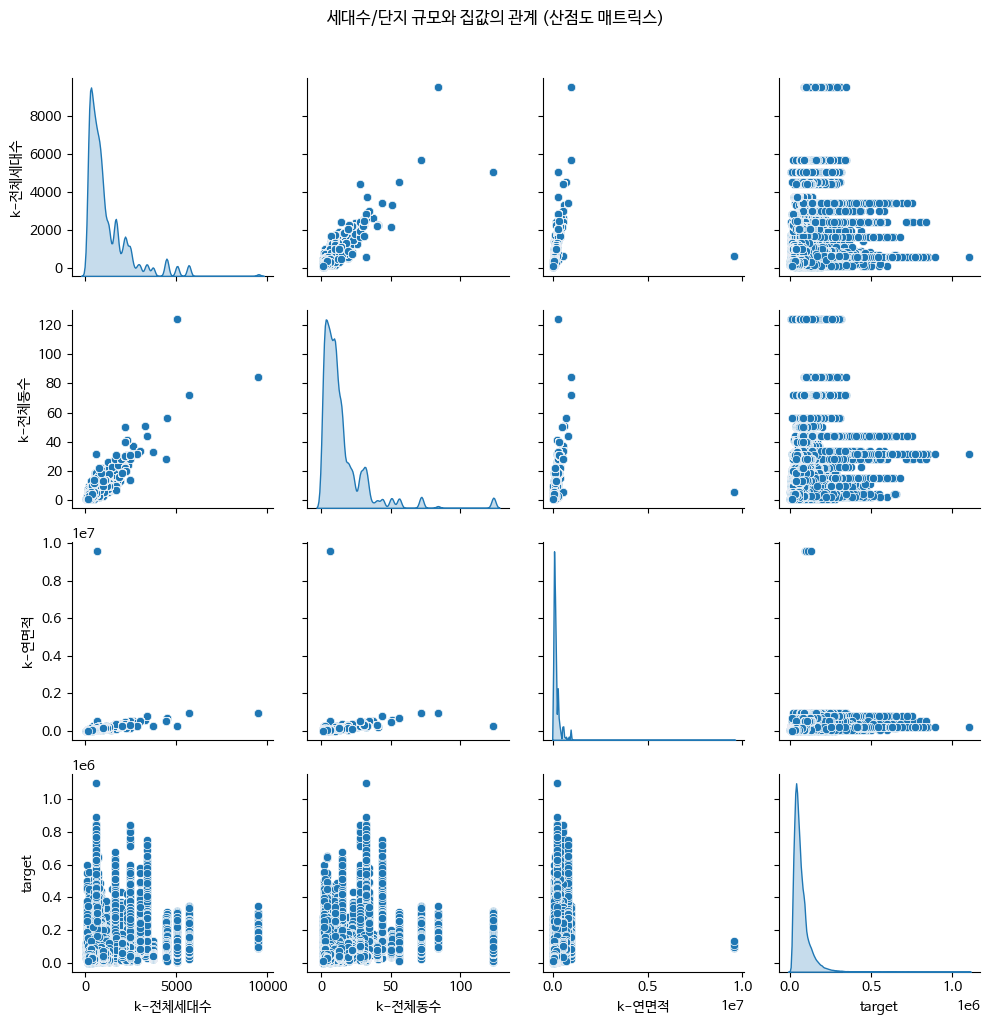

In [116]:
cols = ['k-전체세대수', 'k-전체동수', 'k-연면적', 'target']
# 결측치 제거
plot_df = df[cols].dropna()

# 산점도 행렬 그리기
sns.pairplot(plot_df, diag_kind='kde')
plt.suptitle('세대수/단지 규모와 집값의 관계 (산점도 매트릭스)', y=1.02)
plt.tight_layout()
plt.show()

### 난방방식별 집값 관계

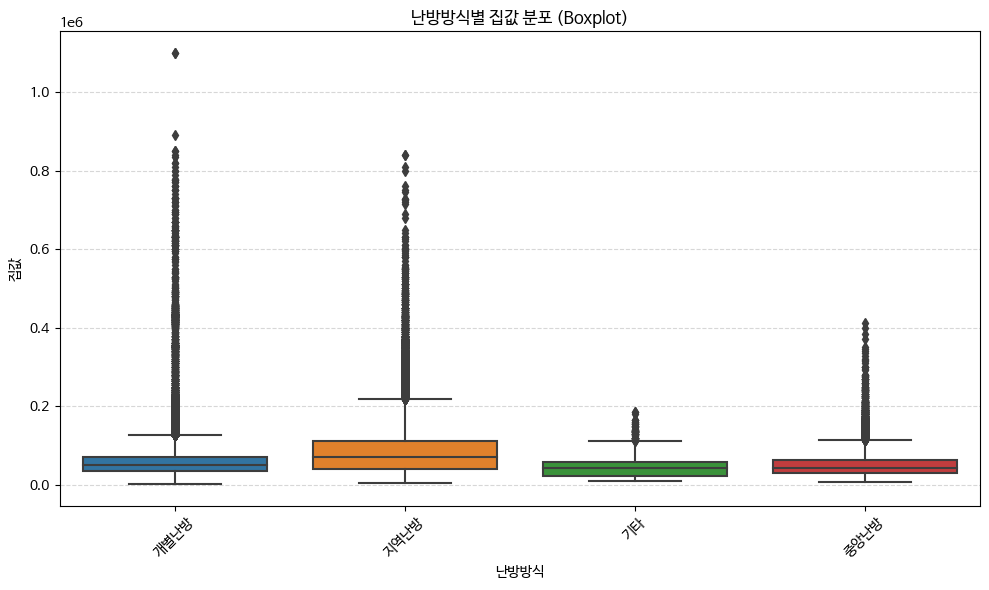

In [117]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='k-난방방식', y='target')
plt.title('난방방식별 집값 분포 (Boxplot)')
plt.xlabel('난방방식')
plt.ylabel('집값')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

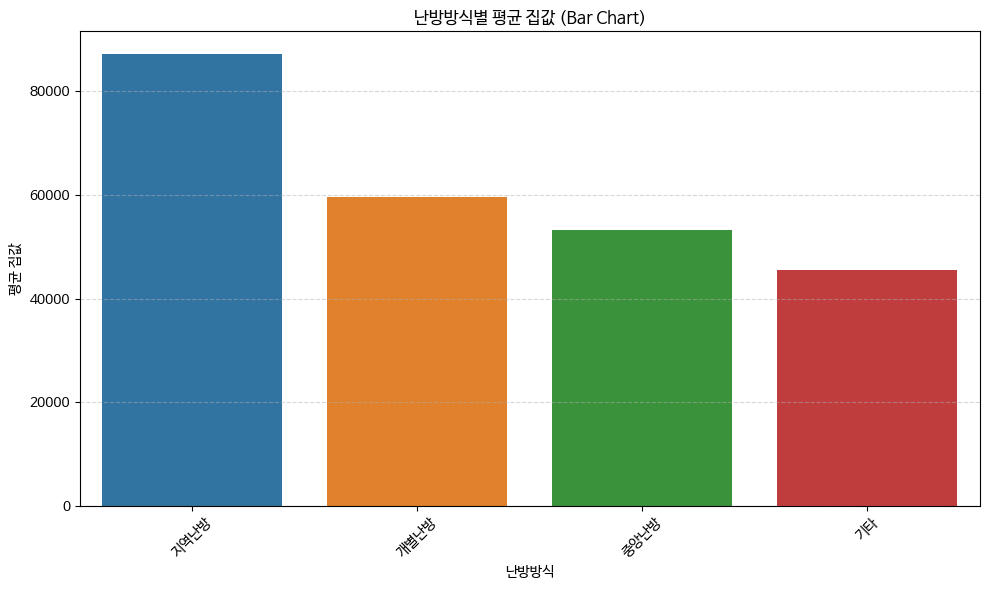

In [118]:
# 평균 집값 계산
heating_price = df.groupby('k-난방방식')['target'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=heating_price.index, y=heating_price.values)
plt.title('난방방식별 평균 집값 (Bar Chart)')
plt.xlabel('난방방식')
plt.ylabel('평균 집값')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 관리방식별 집값 관계

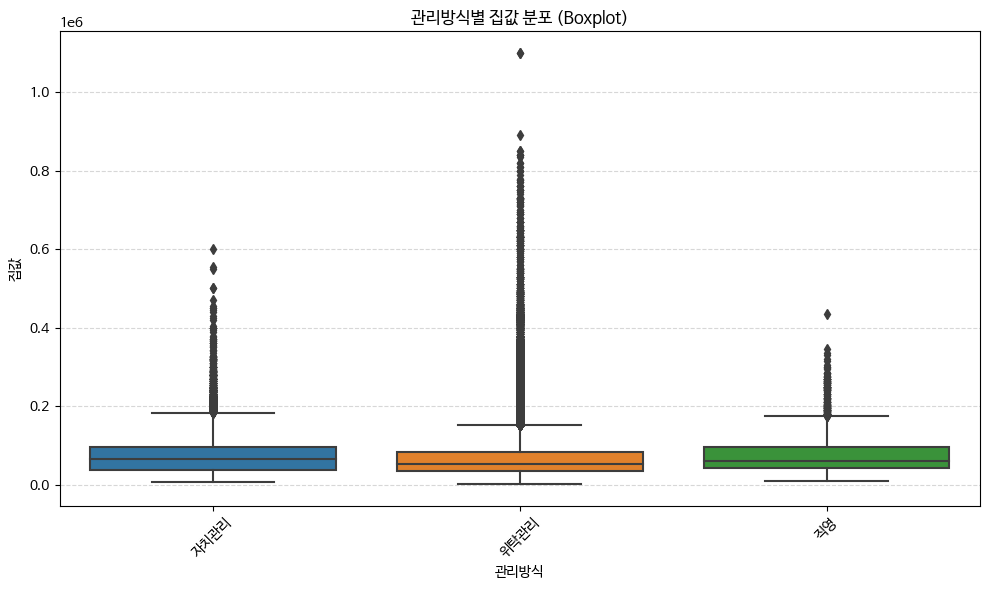

In [119]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='k-관리방식', y='target')
plt.title('관리방식별 집값 분포 (Boxplot)')
plt.xlabel('관리방식')
plt.ylabel('집값')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 세대타입별 집값관계

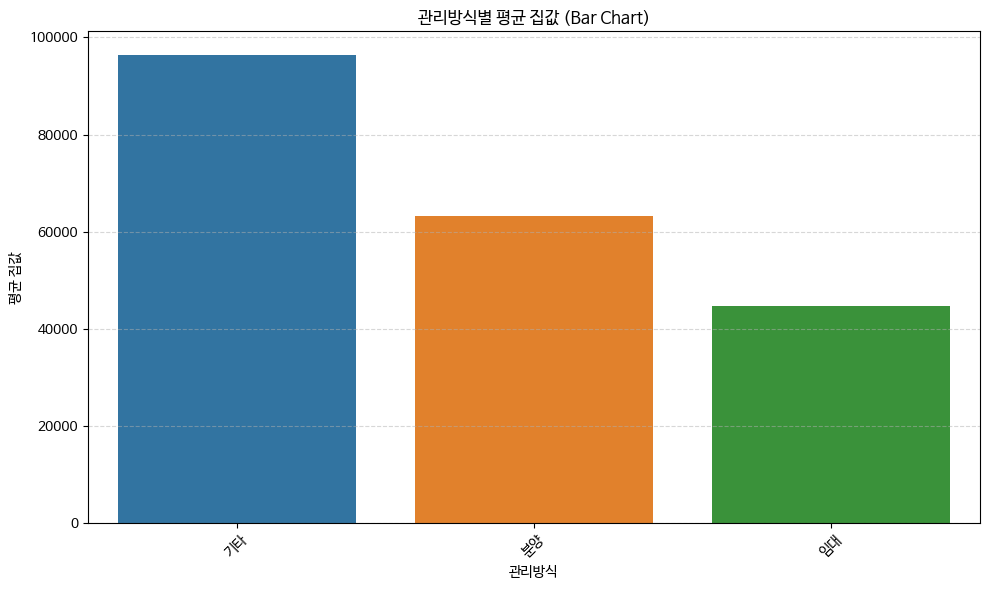

In [ ]:
# k-세대타입(분양형태)별별 평균 집값 계산
mgmt_price = df.groupby('k-세대타입(분양형태)')['target'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mgmt_price.index, y=mgmt_price.values)
plt.title('세대타입별 평균 집값 (Bar Chart)')
plt.xlabel('세대타입')
plt.ylabel('평균 집값')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 관리방식별 집값 관계

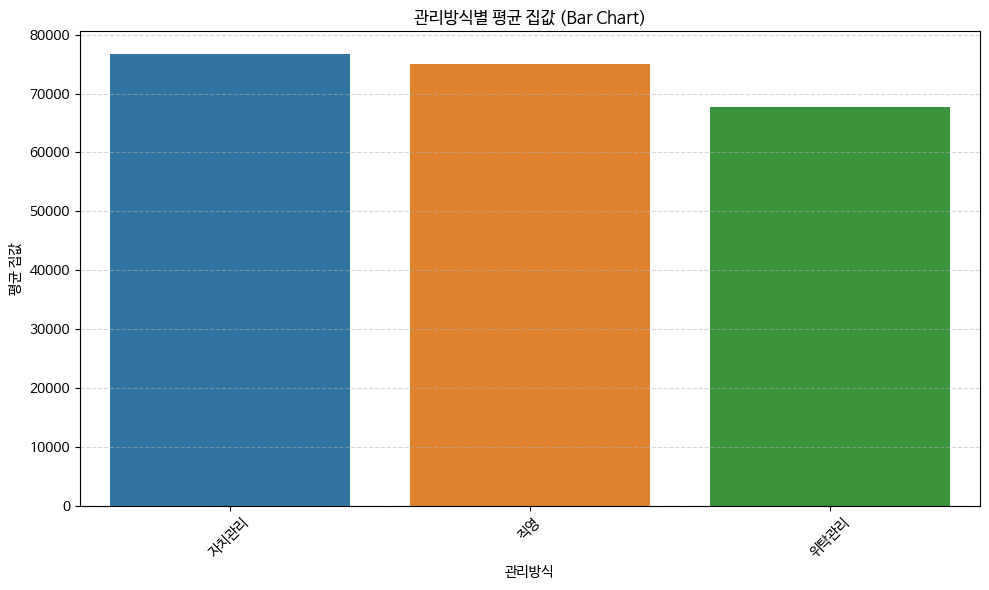

In [120]:
# 관리방식별 평균 집값 계산
mgmt_price = df.groupby('k-관리방식')['target'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mgmt_price.index, y=mgmt_price.values)
plt.title('관리방식별 평균 집값 (Bar Chart)')
plt.xlabel('관리방식')
plt.ylabel('평균 집값')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 복도유형별 집값 관계

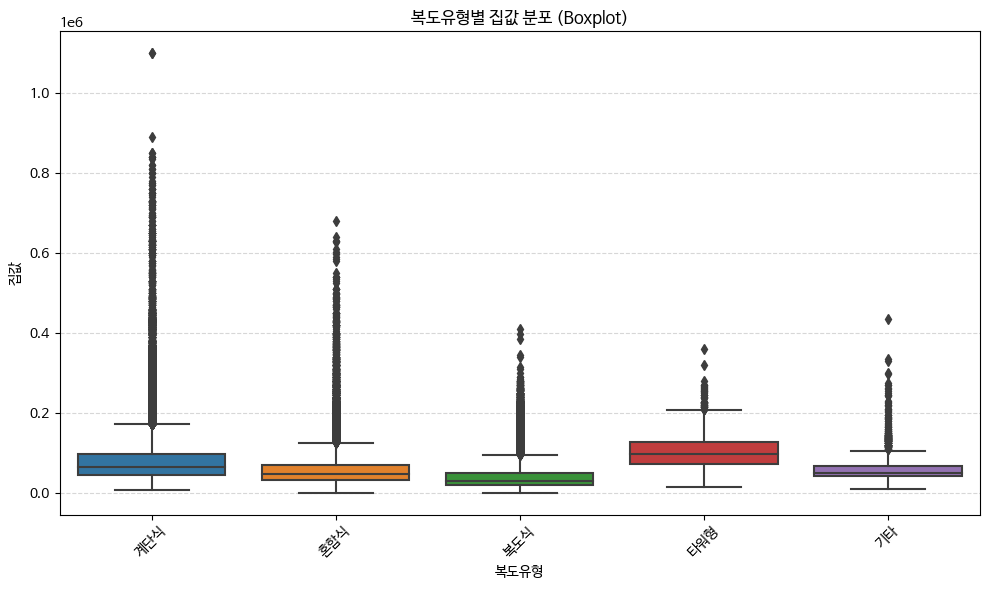

In [121]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='k-복도유형', y='target')
plt.title('복도유형별 집값 분포 (Boxplot)')
plt.xlabel('복도유형')
plt.ylabel('집값')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

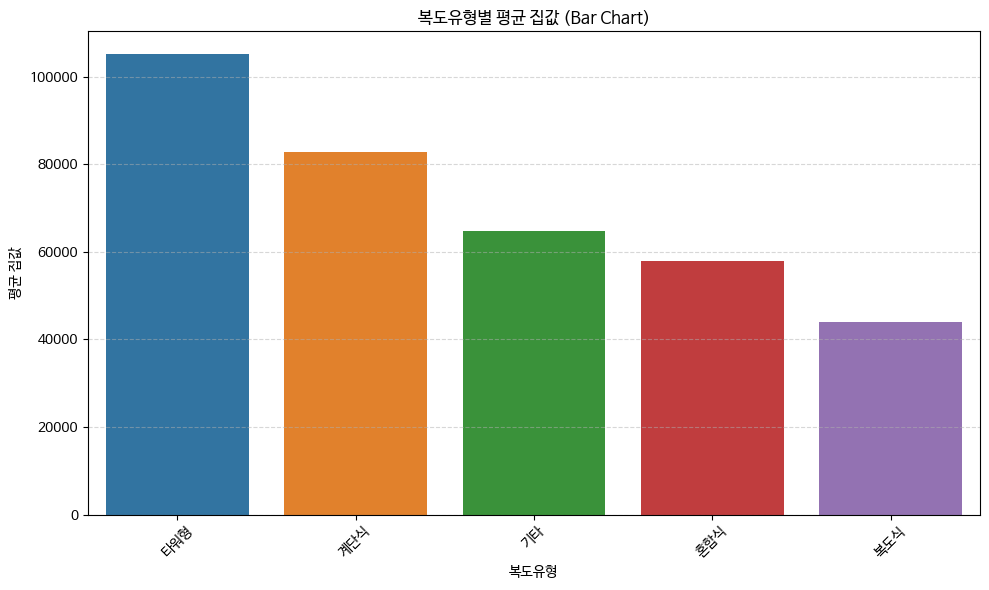

In [ ]:
# 복도유형별 평균 집값 계산
hallway_price = df.groupby('k-복도유형')['target'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=hallway_price.index, y=hallway_price.values)
plt.title('복도유형별 평균 집값 (Bar Chart)')
plt.xlabel('복도유형')
plt.ylabel('평균 집값')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 경비비관리형태별 집값 관계

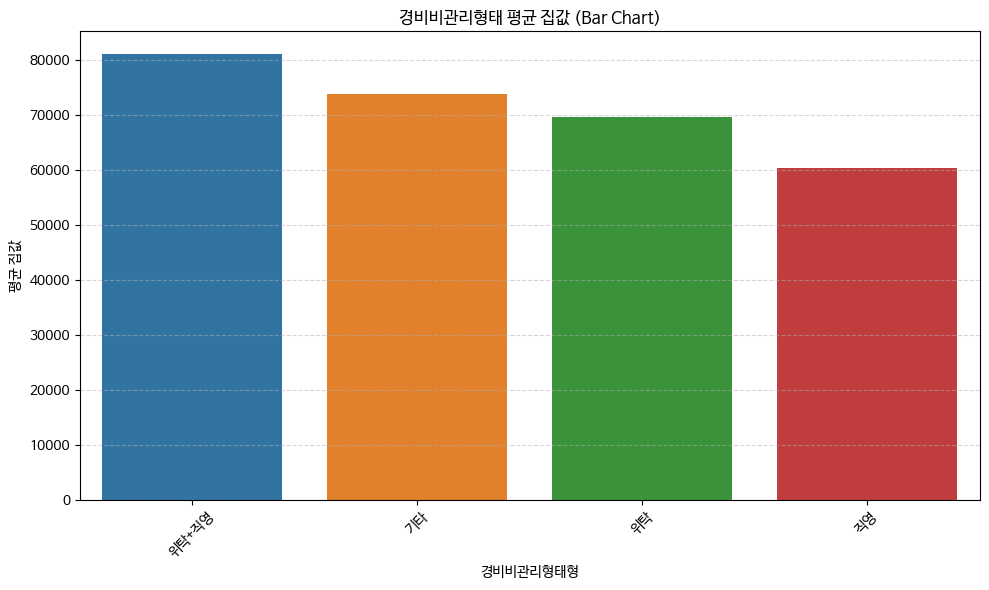

In [28]:
# 복도유형별 평균 집값 계산
hallway_price = df.groupby('경비비관리형태')['target'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=hallway_price.index, y=hallway_price.values)
plt.title('경비비관리형태 평균 집값 (Bar Chart)')
plt.xlabel('경비비관리형태형')
plt.ylabel('평균 집값')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 건설사와 집값 관계

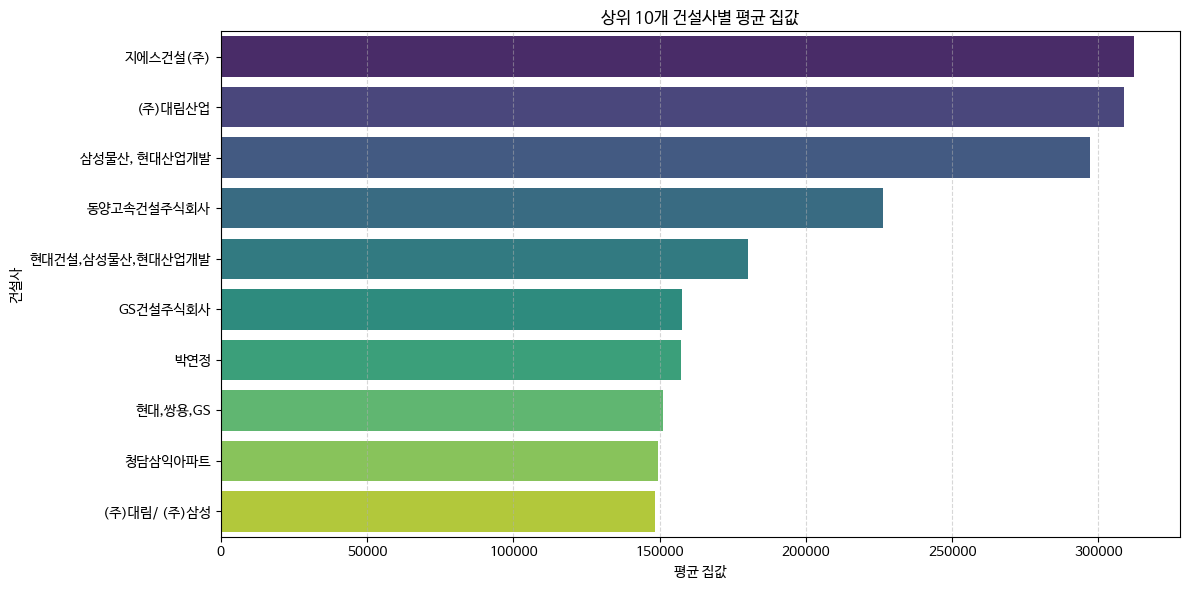

In [124]:

# 결측치 제거 및 건설사별 평균 집값 계산
top_builders = (
    df.dropna(subset=['k-건설사(시공사)', 'target'])
      .groupby('k-건설사(시공사)')['target']
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=top_builders.values, y=top_builders.index, palette='viridis')
plt.title('상위 10개 건설사별 평균 집값')
plt.xlabel('평균 집값')
plt.ylabel('건설사')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 결측값 조사

In [125]:
df.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)',
       'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', 'target', 'is_test', '계약연도', '계약월', '계약년월_dt', '시', '구', '동',
       '층구간'],
      dtype='object')

In [126]:
# 전체 결측값 현황 확인
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_df = pd.concat([missing_values, missing_percent], axis=1, 
                       keys=['결측값 수', '결측값 비율(%)'])
print("전체 결측값 현황:")
print(missing_df[missing_df['결측값 수'] > 0].head(50))

전체 결측값 현황:
                         결측값 수  결측값 비율(%)
고용보험관리번호                920757  81.620592
세대전기계약방법                885389  78.485392
k-팩스번호                  879348  77.949887
k-시행사                   877834  77.815678
청소비관리형태                 877751  77.808321
k-건설사(시공사)              877637  77.798215
경비비관리형태                 877561  77.791478
k-단지분류(아파트,주상복합등등)      877273  77.765949
k-전체동수                  877207  77.760098
단지승인일                   876854  77.728806
k-전화번호                  876850  77.728452
k-복도유형                  876454  77.693348
건축면적                    876279  77.677835
주차대수                    876277  77.677658
k-사용검사일-사용승인일           876259  77.676062
좌표Y                     876232  77.673669
좌표X                     876232  77.673669
단지신청일                   876187  77.669680
k-전용면적별세대현황(60㎡~85㎡이하)  876170  77.668173
k-85㎡~135㎡이하            876170  77.668173
k-주거전용면적                876170  77.668173
k-수정일자                  876170  77.668173
k-전용면적별세대현황(60㎡이하)     

### 아파트 명으로 결측값 채울수있을지

In [100]:
# 아파트명별 결측값 패턴 확인
print("\n아파트명별 결측값 패턴 분석:")
# 아파트명별 결측값 그룹핑
apt_missing = df.groupby('아파트명').apply(lambda x: x[['좌표X', '좌표Y', '건축면적']].isnull().sum())
apt_missing_counts = apt_missing.reset_index()
apt_missing_counts['총 결측 컬럼 수'] = apt_missing_counts[['좌표X', '좌표Y', '건축면적']].sum(axis=1)
# 결측값이 있는 아파트 수 확인
apts_with_x_missing = apt_missing_counts[apt_missing_counts['좌표X'] > 0].shape[0]
apts_with_y_missing = apt_missing_counts[apt_missing_counts['좌표Y'] > 0].shape[0]
apts_with_area_missing = apt_missing_counts[apt_missing_counts['건축면적'] > 0].shape[0]

print(f"좌표X 결측값이 있는 아파트 수: {apts_with_x_missing}")
print(f"좌표Y 결측값이 있는 아파트 수: {apts_with_y_missing}")
print(f"건축면적 결측값이 있는 아파트 수: {apts_with_area_missing}")


아파트명별 결측값 패턴 분석:
좌표X 결측값이 있는 아파트 수: 5867
좌표Y 결측값이 있는 아파트 수: 5867
건축면적 결측값이 있는 아파트 수: 5868


In [101]:
# 아파트별 결측 패턴이 일관적인지 확인
print("\n아파트별 결측 패턴 일관성 확인:")
# 각 아파트의 모든 행에서 동일하게 결측값이 발생하는지 확인
def check_consistency(apt_name):
    apt_data = df[df['아파트명'] == apt_name]
    x_missing = apt_data['좌표X'].isnull().value_counts(normalize=True)
    y_missing = apt_data['좌표Y'].isnull().value_counts(normalize=True)
    area_missing = apt_data['건축면적'].isnull().value_counts(normalize=True)
    
    # True는 결측, False는 비결측을 의미
    x_consistent = len(x_missing) == 1  # 모두 결측이거나 모두 비결측
    y_consistent = len(y_missing) == 1
    area_consistent = len(area_missing) == 1
    
    return x_consistent, y_consistent, area_consistent

# 결측값이 있는 아파트들에 대해 일관성 확인
apts_with_missing = apt_missing_counts[apt_missing_counts['총 결측 컬럼 수'] > 0]['아파트명'].unique()
consistency_results = []

for apt in apts_with_missing[:20]:  # 결측값이 있는 아파트 중 20개만 샘플로 확인
    x_cons, y_cons, area_cons = check_consistency(apt)
    consistency_results.append({
        '아파트명': apt,
        'X좌표 일관성': x_cons,
        'Y좌표 일관성': y_cons,
        '건축면적 일관성': area_cons
    })

cons_df = pd.DataFrame(consistency_results)
print(cons_df)


아파트별 결측 패턴 일관성 확인:
          아파트명  X좌표 일관성  Y좌표 일관성  건축면적 일관성
0       153-25     True     True      True
1     201호 미공시     True     True      True
2         2차한양     True     True      True
3     3RU-City     True     True      True
4     3차신성미소지움     True     True      True
5         57-0     True     True      True
6       67디벨리움     True     True      True
7       800-19     True     True      True
8       800-22     True     True      True
9       800-27     True     True      True
10      800-30     True     True      True
11      801-14     True     True      True
12       801-9     True     True      True
13      807-39     True     True      True
14      807-41     True     True      True
15    A.G.S.드림     True     True      True
16    APELBAUM     True     True      True
17  AQUADCASAS     True     True      True
18      AZ0213     True     True      True
19   AirPalace     True     True      True


In [102]:
# 결측값 패턴 상관관계 확인 - 특정 컬럼들이 함께 결측되는지
print("\n결측값 패턴 상관관계:")
missing_pattern = df[['좌표X', '좌표Y', '건축면적', '아파트명']].isnull()
correlation = missing_pattern.corr()
print(correlation)


결측값 패턴 상관관계:
           좌표X       좌표Y      건축면적      아파트명
좌표X   1.000000  1.000000  0.999650  0.023351
좌표Y   1.000000  1.000000  0.999650  0.023351
건축면적  0.999650  0.999650  1.000000  0.023349
아파트명  0.023351  0.023351  0.023349  1.000000


In [103]:
# 결측값이 있는 행과 없는 행의 특성 비교
print("\n결측값 유무에 따른 특성 비교:")
has_missing = df[df[['좌표X', '좌표Y', '건축면적']].isnull().any(axis=1)]
no_missing = df[~df[['좌표X', '좌표Y', '건축면적']].isnull().any(axis=1)]

print(f"결측값이 있는 행: {len(has_missing)}")
print(f"결측값이 없는 행: {len(no_missing)}")


결측값 유무에 따른 특성 비교:
결측값이 있는 행: 876324
결측값이 없는 행: 251770


In [104]:
# 결측값 패턴과 시군구나 계약연도 등의 관계 확인
print("\n시군구별 결측값 비율:")
missing_by_district = df.groupby('시군구')[['좌표X', '좌표Y', '건축면적']].apply(
    lambda x: x.isnull().mean() * 100)
print(missing_by_district.sort_values(by='좌표X', ascending=False).head())


시군구별 결측값 비율:
                    좌표X    좌표Y   건축면적
시군구                                  
서울특별시 성북구 삼선동5가   100.0  100.0  100.0
서울특별시 용산구 이태원동    100.0  100.0  100.0
서울특별시 영등포구 당산동1가  100.0  100.0  100.0
서울특별시 영등포구 당산동2가  100.0  100.0  100.0
서울특별시 영등포구 당산동6가  100.0  100.0  100.0


In [105]:
print("\n계약연도별 결측값 비율:")
missing_by_year = df.groupby('계약연도')[['좌표X', '좌표Y', '건축면적']].apply(
    lambda x: x.isnull().mean() * 100)
print(missing_by_year.sort_values(by='좌표X', ascending=False).head())


계약연도별 결측값 비율:
            좌표X        좌표Y       건축면적
계약연도                                 
2007  83.410758  83.410758  83.427774
2008  82.549288  82.549288  82.558058
2010  80.574488  80.574488  80.581236
2022  79.498936  79.498936  79.515310
2009  79.251881  79.251881  79.249160


### 동기준으로 결측치 확인해보기

In [106]:
# '동' 기준으로 결측값 패턴 확인
print("'동' 기준 결측값 패턴 분석:")

# 동별 결측값 비율 계산
dong_missing = df.groupby('동')[['좌표X', '좌표Y', '건축면적']].apply(
    lambda x: x.isnull().mean() * 100)

# 결측값 비율이 가장 높은 동 상위 20개 출력
print("\n결측값 비율이 높은 동 상위 20개:")
print(dong_missing.sort_values(by='좌표X', ascending=False).head(20))

# 결측값이 있는 동의 수 계산
dongs_with_x_missing = dong_missing[dong_missing['좌표X'] > 0].shape[0]
dongs_with_y_missing = dong_missing[dong_missing['좌표Y'] > 0].shape[0]
dongs_with_area_missing = dong_missing[dong_missing['건축면적'] > 0].shape[0]

print(f"\n좌표X 결측값이 있는 동 수: {dongs_with_x_missing}")
print(f"좌표Y 결측값이 있는 동 수: {dongs_with_y_missing}")
print(f"건축면적 결측값이 있는 동 수: {dongs_with_area_missing}")

'동' 기준 결측값 패턴 분석:

결측값 비율이 높은 동 상위 20개:
          좌표X    좌표Y   건축면적
동                          
천연동     100.0  100.0  100.0
미근동     100.0  100.0  100.0
합동      100.0  100.0  100.0
옥인동     100.0  100.0  100.0
방이동     100.0  100.0  100.0
오장동     100.0  100.0  100.0
보광동     100.0  100.0  100.0
보문동2가   100.0  100.0  100.0
보문동4가   100.0  100.0  100.0
예장동     100.0  100.0  100.0
충신동     100.0  100.0  100.0
영등포동5가  100.0  100.0  100.0
부암동     100.0  100.0  100.0
한강로3가   100.0  100.0  100.0
영등포동4가  100.0  100.0  100.0
사근동     100.0  100.0  100.0
영등포동3가  100.0  100.0  100.0
사직동     100.0  100.0  100.0
산림동     100.0  100.0  100.0
충무로5가   100.0  100.0  100.0

좌표X 결측값이 있는 동 수: 332
좌표Y 결측값이 있는 동 수: 332
건축면적 결측값이 있는 동 수: 332



동별 결측 패턴 일관성 확인:

가락동 지역 아파트별 결측값 비율:
                       좌표X    좌표Y   건축면적
아파트명                                    
e지브로                 100.0  100.0  100.0
sk파크타워               100.0  100.0  100.0
가락3차쌍용스윗닷홈           100.0  100.0  100.0
가락3차쌍용스윗닷홈101동,102동  100.0  100.0  100.0
가락그랑밸리               100.0  100.0  100.0
...                    ...    ...    ...
현대                   100.0  100.0  100.0
현대7                  100.0  100.0  100.0
현대빌라트1               100.0  100.0  100.0
현대파크빌                100.0  100.0  100.0
현진타워                 100.0  100.0  100.0

[75 rows x 3 columns]
가락동 내 좌표X 결측값 있는 아파트 수: 71
가락동 내 좌표X 결측값 없는 아파트 수: 4

가리봉동 지역 아파트별 결측값 비율:
         좌표X    좌표Y   건축면적
아파트명                      
미래하이츠  100.0  100.0  100.0
효성     100.0  100.0  100.0
가리봉동 내 좌표X 결측값 있는 아파트 수: 2
가리봉동 내 좌표X 결측값 없는 아파트 수: 0

가산동 지역 아파트별 결측값 비율:
               좌표X    좌표Y   건축면적
아파트명                            
G밸리페트라힐스     100.0  100.0  100.0
가산양우내안에애플    100.0  100.0  100.0
가산지웰에스테이트    10

<Figure size 1500x800 with 0 Axes>

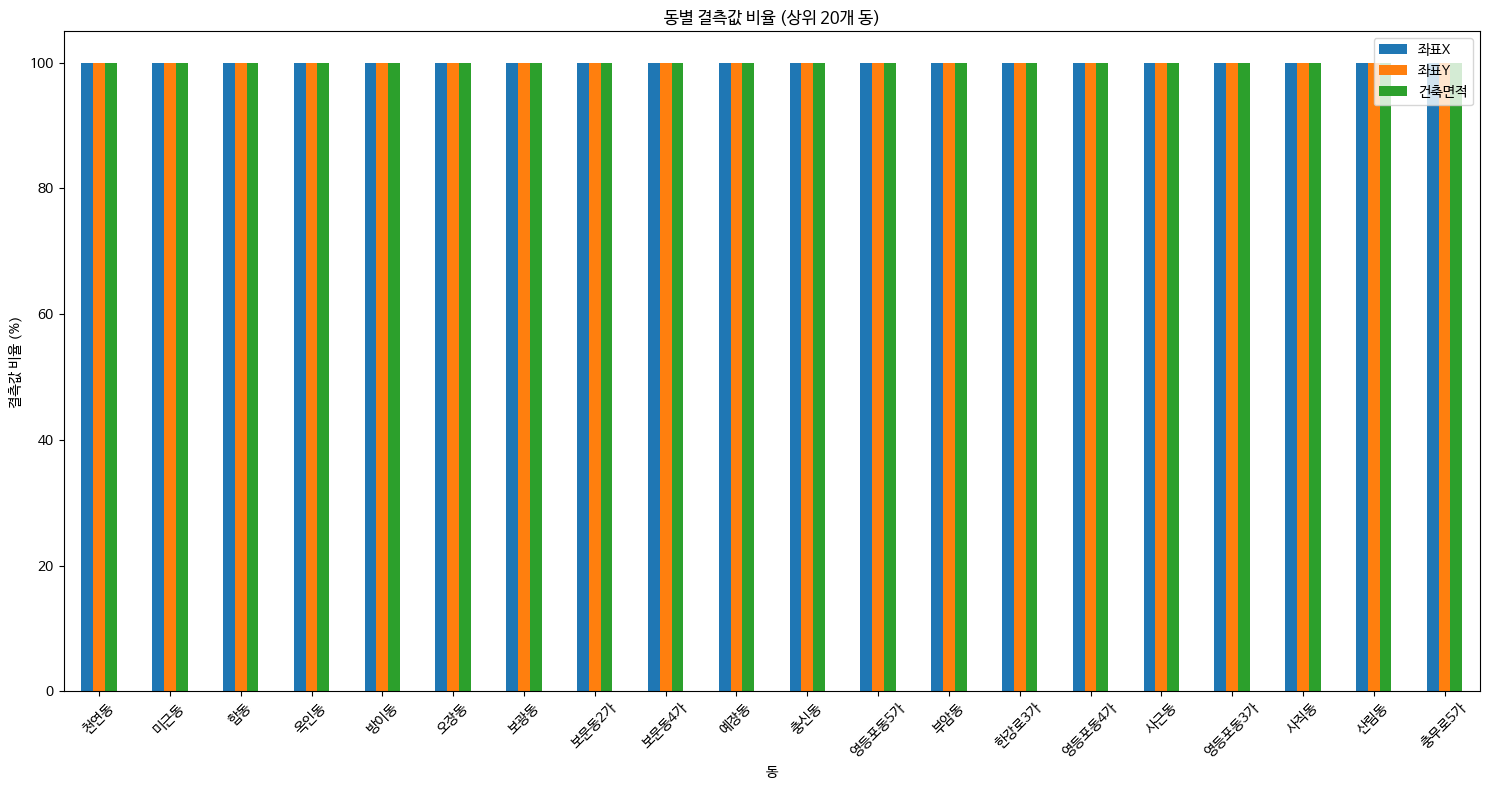

In [107]:
#동별로 결측 패턴이 일관적인지 확인
print("\n동별 결측 패턴 일관성 확인:")

# 결측값 비율이 50% 이상인 동들 추출
high_missing_dongs = dong_missing[(dong_missing['좌표X'] > 50) | 
                                  (dong_missing['좌표Y'] > 50) | 
                                  (dong_missing['건축면적'] > 50)].index.tolist()

# 각 동별 아파트명과 결측값 패턴 분석
for dong in high_missing_dongs[:10]:  # 상위 10개 동만 샘플로 분석
    dong_data = df[df['동'] == dong]
    missing_by_apt = dong_data.groupby('아파트명')[['좌표X', '좌표Y', '건축면적']].apply(
        lambda x: x.isnull().mean() * 100)
    
    print(f"\n{dong} 지역 아파트별 결측값 비율:")
    print(missing_by_apt)
    
    # 동일 동 내에서 아파트별 결측값 패턴의 다양성 확인
    apt_with_missing_x = missing_by_apt[missing_by_apt['좌표X'] > 0].shape[0]
    apt_with_complete_x = missing_by_apt[missing_by_apt['좌표X'] == 0].shape[0]
    
    print(f"{dong} 내 좌표X 결측값 있는 아파트 수: {apt_with_missing_x}")
    print(f"{dong} 내 좌표X 결측값 없는 아파트 수: {apt_with_complete_x}")

# 동과 결측값 패턴 간의 관계 시각화
plt.figure(figsize=(15, 8))
dong_missing_sorted = dong_missing.sort_values(by='좌표X', ascending=False).head(20)
dong_missing_sorted[['좌표X', '좌표Y', '건축면적']].plot(kind='bar', figsize=(15, 8))
plt.title('동별 결측값 비율 (상위 20개 동)')
plt.xlabel('동')
plt.ylabel('결측값 비율 (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [54]:
# 특정 동 내에서 결측값이 있는 건물과 없는 건물의 특성 비교
print("\n결측값 패턴과 건물 특성과의 관계:")
if high_missing_dongs:
    sample_dong = high_missing_dongs[0]
    dong_data = df[df['동'] == sample_dong]
    
    buildings_with_missing = dong_data[dong_data['좌표X'].isnull()]['아파트명'].unique()
    buildings_without_missing = dong_data[~dong_data['좌표X'].isnull()]['아파트명'].unique()
    
    print(f"{sample_dong} 내 좌표X 결측값 있는 건물: {', '.join(buildings_with_missing[:5])}... (총 {len(buildings_with_missing)}개)")
    print(f"{sample_dong} 내 좌표X 결측값 없는 건물: {', '.join(buildings_without_missing[:5])}... (총 {len(buildings_without_missing)}개)")
    
    # 건축년도와 결측값 관계 확인
    if '건축년도' in dong_data.columns:
        missing_build_year = dong_data[dong_data['좌표X'].isnull()]['건축년도'].mean()
        complete_build_year = dong_data[~dong_data['좌표X'].isnull()]['건축년도'].mean()
        
        print(f"\n결측값 있는 건물 평균 건축년도: {missing_build_year:.2f}")
        print(f"결측값 없는 건물 평균 건축년도: {complete_build_year:.2f}")


결측값 패턴과 건물 특성과의 관계:
가락동 내 좌표X 결측값 있는 건물: e지브로, sk파크타워, 가락쌍용, 가락3차쌍용스윗닷홈, 가락3차쌍용스윗닷홈101동,102동... (총 71개)
가락동 내 좌표X 결측값 없는 건물: 가락금호, 가락미륭, 한화오벨리스크, 헬리오시티... (총 4개)

결측값 있는 건물 평균 건축년도: 1992.13
결측값 없는 건물 평균 건축년도: 2001.66


In [109]:
# 구와 동 조합별 결측값 패턴 확인
print("\n구-동 조합별 결측값 패턴:")
gu_dong_missing = df.groupby(['구', '동'])[['좌표X', '좌표Y', '건축면적']].apply(
    lambda x: x.isnull().mean() * 100)
print(gu_dong_missing.sort_values(by='좌표X', ascending=False).head(10))


구-동 조합별 결측값 패턴:
              좌표X    좌표Y   건축면적
구    동                         
성북구  삼선동5가  100.0  100.0  100.0
용산구  이태원동   100.0  100.0  100.0
영등포구 당산동1가  100.0  100.0  100.0
     당산동2가  100.0  100.0  100.0
     당산동6가  100.0  100.0  100.0
     문래동2가  100.0  100.0  100.0
     문래동4가  100.0  100.0  100.0
     양평동1가  100.0  100.0  100.0
     양평동3가  100.0  100.0  100.0
     양평동6가  100.0  100.0  100.0


### 다른 변수들도 결측값 패턴 분석

In [ ]:
# 결측값 컬럼별 패턴 분석
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# 결측치가 있는 주요 컬럼 그룹화
location_cols = ['좌표X', '좌표Y']
building_info_cols = ['건축면적', '주차대수', 'k-전체동수', 'k-복도유형']
date_cols = ['단지승인일', 'k-사용검사일-사용승인일', 'k-수정일자', '단지신청일']
facility_cols = ['세대전기계약방법', '경비비관리형태', '청소비관리형태']
company_cols = ['k-건설사(시공사)', 'k-시행사', '고용보험관리번호']
contact_cols = ['k-전화번호', 'k-팩스번호']
area_cols = ['k-전용면적별세대현황(60㎡~85㎡이하)']

# 결측값 일치 패턴 확인
print("주요 결측값 컬럼 간 결측 패턴 일치 여부 확인:")

# 위치 정보와 건물 정보 결측 패턴 일치 여부
location_missing = df[location_cols].isnull().all(axis=1)
building_missing = df[building_info_cols].isnull().all(axis=1)
date_missing = df[date_cols].isnull().all(axis=1)
facility_missing = df[facility_cols].isnull().all(axis=1)
company_missing = df[company_cols].isnull().all(axis=1)
contact_missing = df[contact_cols].isnull().all(axis=1)

# 그룹별 결측 패턴 일치율
print(f"위치 정보와 건물 정보 결측 패턴 일치율: {(location_missing == building_missing).mean() * 100:.2f}%")
print(f"위치 정보와 날짜 정보 결측 패턴 일치율: {(location_missing == date_missing).mean() * 100:.2f}%")
print(f"위치 정보와 시설 관리 정보 결측 패턴 일치율: {(location_missing == facility_missing).mean() * 100:.2f}%")
print(f"위치 정보와 회사 정보 결측 패턴 일치율: {(location_missing == company_missing).mean() * 100:.2f}%")
print(f"위치 정보와 연락처 정보 결측 패턴 일치율: {(location_missing == contact_missing).mean() * 100:.2f}%")

주요 결측값 컬럼 간 결측 패턴 일치 여부 확인:
위치 정보와 건물 정보 결측 패턴 일치율: 99.99%
위치 정보와 날짜 정보 결측 패턴 일치율: 99.99%
위치 정보와 시설 관리 정보 결측 패턴 일치율: 99.92%
위치 정보와 회사 정보 결측 패턴 일치율: 99.91%
위치 정보와 연락처 정보 결측 패턴 일치율: 99.93%


In [111]:
# 아파트명별 결측 패턴 확인
print("\n아파트명별 결측 패턴:")
apt_missing_pattern = df.groupby('아파트명').apply(
    lambda x: pd.Series({
        '좌표결측비율': x[location_cols].isnull().all(axis=1).mean(),
        '건물정보결측비율': x[building_info_cols].isnull().all(axis=1).mean(),
        '날짜정보결측비율': x[date_cols].isnull().all(axis=1).mean(),
        '시설관리결측비율': x[facility_cols].isnull().all(axis=1).mean(),
        '회사정보결측비율': x[company_cols].isnull().all(axis=1).mean(),
        '연락처결측비율': x[contact_cols].isnull().all(axis=1).mean(),
        '데이터수': len(x)
    })
)

# 아파트별 결측 패턴이 일관된 경우와 일관되지 않은 경우 확인
consistent_missing = apt_missing_pattern[
    (apt_missing_pattern['좌표결측비율'].isin([0, 1])) &
    (apt_missing_pattern['건물정보결측비율'].isin([0, 1])) &
    (apt_missing_pattern['날짜정보결측비율'].isin([0, 1])) &
    (apt_missing_pattern['시설관리결측비율'].isin([0, 1])) &
    (apt_missing_pattern['회사정보결측비율'].isin([0, 1])) &
    (apt_missing_pattern['연락처결측비율'].isin([0, 1]))
]

print(f"결측 패턴이 일관된 아파트 수: {len(consistent_missing)}")
print(f"전체 아파트 중 비율: {len(consistent_missing) / len(apt_missing_pattern) * 100:.2f}%")


아파트명별 결측 패턴:
결측 패턴이 일관된 아파트 수: 6496
전체 아파트 중 비율: 99.19%


In [112]:
# 동별 결측 패턴 확인
print("\n동별 결측 패턴:")
dong_missing_pattern = df.groupby('동').apply(
    lambda x: pd.Series({
        '좌표결측비율': x[location_cols].isnull().all(axis=1).mean(),
        '건물정보결측비율': x[building_info_cols].isnull().all(axis=1).mean(),
        '날짜정보결측비율': x[date_cols].isnull().all(axis=1).mean(),
        '시설관리결측비율': x[facility_cols].isnull().all(axis=1).mean(),
        '회사정보결측비율': x[company_cols].isnull().all(axis=1).mean(),
        '연락처결측비율': x[contact_cols].isnull().all(axis=1).mean(),
        '데이터수': len(x)
    })
)

# 동별 결측 패턴이 일관된 경우와 일관되지 않은 경우 확인
dong_consistent_missing = dong_missing_pattern[
    (dong_missing_pattern['좌표결측비율'] > 0.95) | (dong_missing_pattern['좌표결측비율'] < 0.05)
]

print(f"결측 패턴이 명확한 동 수: {len(dong_consistent_missing)}")
print(f"전체 동 중 비율: {len(dong_consistent_missing) / len(dong_missing_pattern) * 100:.2f}%")


동별 결측 패턴:
결측 패턴이 명확한 동 수: 166
전체 동 중 비율: 49.26%


In [113]:
# 시간에 따른 결측 패턴 변화 확인
print("\n계약연도별 결측 패턴:")
year_missing_pattern = df.groupby('계약연도').apply(
    lambda x: pd.Series({
        '좌표결측비율': x[location_cols].isnull().all(axis=1).mean() * 100,
        '건물정보결측비율': x[building_info_cols].isnull().all(axis=1).mean() * 100,
        '날짜정보결측비율': x[date_cols].isnull().all(axis=1).mean() * 100,
        '시설관리결측비율': x[facility_cols].isnull().all(axis=1).mean() * 100,
        '회사정보결측비율': x[company_cols].isnull().all(axis=1).mean() * 100,
        '연락처결측비율': x[contact_cols].isnull().all(axis=1).mean() * 100,
        '데이터수': len(x)
    })
)

print(year_missing_pattern.sort_index())



계약연도별 결측 패턴:
         좌표결측비율   건물정보결측비율   날짜정보결측비율   시설관리결측비율   회사정보결측비율    연락처결측비율  \
계약연도                                                                     
2007  83.410758  83.405653  83.405653  83.414161  83.431177  83.412459   
2008  82.549288  82.538764  82.538764  82.554550  82.565074  82.552796   
2009  79.251881  79.240995  79.240995  79.251881  79.279095  79.260045   
2010  80.574488  80.567740  80.567740  80.578986  80.596981  80.585735   
2011  79.215967  79.210464  79.210464  79.283841  79.236146  79.234311   
2012  78.639446  78.636998  78.636998  78.676165  78.659029  78.646790   
2013  77.192957  77.192957  77.192957  77.400722  77.222427  77.209165   
2014  76.922354  76.917655  76.917655  76.958769  77.087983  77.075062   
2015  77.502064  77.496226  77.496226  77.561285  77.560451  77.542101   
2016  76.262682  76.245554  76.245554  76.324141  76.346307  76.333209   
2017  75.400646  75.391113  75.391113  75.484541  75.494075  75.488355   
2018  76.635181  76.6216

In [114]:
# 구별 결측 패턴 확인
print("\n구별 결측 패턴:")
gu_missing_pattern = df.groupby('구').apply(
    lambda x: pd.Series({
        '좌표결측비율': x[location_cols].isnull().all(axis=1).mean() * 100,
        '건물정보결측비율': x[building_info_cols].isnull().all(axis=1).mean() * 100,
        '날짜정보결측비율': x[date_cols].isnull().all(axis=1).mean() * 100,
        '시설관리결측비율': x[facility_cols].isnull().all(axis=1).mean() * 100,
        '회사정보결측비율': x[company_cols].isnull().all(axis=1).mean() * 100,
        '연락처결측비율': x[contact_cols].isnull().all(axis=1).mean() * 100,
        '데이터수': len(x)
    })
)

print(gu_missing_pattern.sort_values(by='좌표결측비율', ascending=False))


구별 결측 패턴:
         좌표결측비율   건물정보결측비율   날짜정보결측비율   시설관리결측비율   회사정보결측비율    연락처결측비율  \
구                                                                        
양천구   92.301758  92.301758  92.301758  92.408295  92.301758  92.301758   
노원구   91.134094  91.134094  91.134094  91.134094  91.134094  91.134094   
중랑구   90.738010  90.738010  90.738010  90.738010  90.738010  90.738010   
중구    86.035171  86.035171  86.035171  86.035171  86.035171  86.035171   
강동구   84.579896  84.579896  84.579896  84.727273  84.579896  84.677613   
강북구   83.367213  83.367213  83.367213  83.367213  83.367213  83.367213   
광진구   81.943196  81.943196  81.943196  81.943196  81.943196  81.943196   
구로구   81.189314  81.189314  81.189314  81.520446  82.208578  82.208578   
도봉구   80.422530  80.422530  80.422530  80.422530  80.422530  80.422530   
관악구   80.299644  80.299644  80.299644  80.299644  80.528654  80.299644   
종로구   80.008711  80.008711  80.008711  80.008711  80.008711  80.008711   
은평구   79.712394  79.712394 